# Customer Clustering: Multi-Perspective Approach

This notebook identifies customer clusters from different perspectives (behavioral, profile), compares clustering algorithms, and merges the best solutions using hierarchical clustering on centroids.

In [1]:
# All required imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import DBSCAN, KMeans, MeanShift, estimate_bandwidth, AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from collections import Counter
from itertools import product
from umap import UMAP
from minisom import MiniSom

import warnings
warnings.filterwarnings('ignore')

# Preprocessing & Feature Engineering

All custom functions for preprocessing, feature engineering, and aggregation are defined below.

In [2]:
def winsorize_dataframe(df, columns, limits=(0.01, 0.01)):
    """
    Apply winsorization to each column in `columns`.
    limits=(lower_pct, upper_pct) means: cap values at the 1st and 99th percentile.

    Returns the winsorized copy of df.
    """
    df = df.copy()
    for col in columns:
        if col in df.columns:
            # winsorize returns masked arrays -> convert to normal array
            df[col] = winsorize(df[col], limits=limits).data
    return df

def preprocess_flights(flights_df: pd.DataFrame) -> pd.DataFrame:
    """
    Apply preprocessing steps to the FlightsDB:
    - Winsorize outliers
    - Convert YearMonthDate to datetime
    - Round down NumFlights and NumFlightsWithCompanions
    - Set DistanceKM = 0 where NumFlights == 0
    - Drop DollarCostPointsRedeemed
    - Add log-transformed versions of skewed variables
    - Create PointsUtilizationRatio = PointsRedeemed / PointsAccumulated
    """
    df = flights_df.copy()

    # 0. Winsorize outliers (Flights DB outliers are legitimate but skewed)
    outlier_cols = [
        'NumFlights', 'NumFlightsWithCompanions', 'DistanceKM', 
        'PointsAccumulated', 'PointsRedeemed'
    ]
    df = winsorize_dataframe(df, outlier_cols, limits=(0.01, 0.01))

    # 1. YearMonthDate -> datetime
    if 'YearMonthDate' in df.columns:
        df['YearMonthDate'] = pd.to_datetime(df['YearMonthDate'])

    # 2. Round down flight counts and cast to int
    for col in ['NumFlights', 'NumFlightsWithCompanions']:
        if col in df.columns:
            df[col] = np.floor(df[col]).astype(int)

    # 3. Fix logical inconsistency: DistanceKM must be 0 if NumFlights == 0
    if {'NumFlights', 'DistanceKM'}.issubset(df.columns):
        df.loc[df['NumFlights'] == 0, 'DistanceKM'] = 0

    # 4. Drop perfectly correlated variable
    if 'DollarCostPointsRedeemed' in df.columns:
        df = df.drop(columns=['DollarCostPointsRedeemed'])

    # 5. Log transforms for skewed numeric variables
    log_cols = ['DistanceKM', 'PointsAccumulated', 'PointsRedeemed', 'NumFlights']
    for col in log_cols:
        if col in df.columns:
            df[f'{col}_log'] = np.log1p(df[col])

    # 6. Points utilisation ratio
    if {'PointsRedeemed', 'PointsAccumulated'}.issubset(df.columns):
        denom = df['PointsAccumulated'].replace({0: np.nan})
        df['PointsUtilizationRatio'] = df['PointsRedeemed'] / denom

    return df

def preprocess_customers(customer_df: pd.DataFrame) -> pd.DataFrame:
    """
    Apply preprocessing steps to the CustomerDB:
    - Create cancellation flag from CancellationDate
    - Group-median imputation (by LoyaltyStatus) for Income and Customer Lifetime Value
    - Winsorize outliers (Income, CLV)
    - Log transform Customer Lifetime Value and Income
    - Encode Gender as binary
    """
    df = customer_df.copy()

    # 1. Cancellation flag
    if 'CancellationDate' in df.columns:
        df['CancelledFlag'] = df['CancellationDate'].notna().astype(int)

    # 2. Group-median imputation by LoyaltyStatus
    group_col = 'LoyaltyStatus'
    cols_to_impute = ['Income', 'Customer Lifetime Value']
    for col in cols_to_impute:
        if col in df.columns and group_col in df.columns:
            df[col] = df.groupby(group_col)[col].transform(
                lambda x: x.fillna(x.median())
            )

    # 3. Winsorize outliers
    outlier_cols = ['Income', 'Customer Lifetime Value']
    df = winsorize_dataframe(df, outlier_cols, limits=(0.01, 0.01))

    # 4. Log transforms
    if 'Customer Lifetime Value' in df.columns:
        df['CLV_log'] = np.log1p(df['Customer Lifetime Value'])
    if 'Income' in df.columns:
        df['Income_log'] = np.log1p(df['Income'].clip(lower=0))

    # 5. Gender encoding
    if 'Gender' in df.columns:
        df['Gender'] = df['Gender'].map({'female': 1, 'male': 0}).fillna(0).astype(int)

    # 6. Education to Years (Ordinal Encoding)
    if 'Education' in df.columns:
        edu_map = {
            'High School or Below': 12,
            'College': 14,
            'Bachelor': 16,
            'Master': 18,
            'Doctor': 21
        }
        df['Education'] = df['Education'].map(edu_map)
        df['Education'] = df['Education'].fillna(16)

    # 7. Turn marital status into a flag
    if 'Marital Status' in df.columns:
        df['Marital Status'] = np.where(df['Marital Status'] != 'Married', 1, 0)

    # 8. Tenure
    ref_date = pd.to_datetime('2022-01-01')
    if 'EnrollmentDateOpening' in df.columns:
        df['EnrollmentDateOpening'] = pd.to_datetime(df['EnrollmentDateOpening'])
        df['TenureMonths'] = (ref_date - df['EnrollmentDateOpening']) / pd.Timedelta(days=30.44)

    return df

def build_customer_flight_features(flights_df: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregate monthly flight records into customer-level features:
    - TotalFlights, TotalDistanceKM, TotalPointsAccumulated, TotalPointsRedeemed
    - MeanPointsUtilization
    - AverageFlightDistance
    """
    id_col = 'Loyalty#'
    df = flights_df.copy()
    
    agg = (
        df
        .groupby(id_col)
        .agg(
            TotalFlights=('NumFlights', 'sum'),
            TotalDistanceKM=('DistanceKM', 'sum'),
            TotalPointsAccumulated=('PointsAccumulated', 'sum'),
            TotalPointsRedeemed=('PointsRedeemed', 'sum'),
            MeanPointsUtilization=('PointsUtilizationRatio', 'mean')
        )
        .reset_index()
    )

    # Log transforms for aggregated features
    for col in ['TotalFlights', 'TotalDistanceKM', 'TotalPointsAccumulated', 'TotalPointsRedeemed']:
        agg[f'{col}_log'] = np.log1p(agg[col])
    
    # Average flight distance
    agg['AverageFlightDistance'] = agg['TotalDistanceKM'] / agg['TotalFlights'].replace({0: np.nan})

    return agg

def create_model_df(customer_df: pd.DataFrame, flights_df: pd.DataFrame) -> pd.DataFrame:
    """
    Orchestrates the creation of the final modeling dataframe:
    1. Preprocess customers and flights
    2. Build customer-level flight features
    3. Merge datasets (Left Join)
    4. Set Loyalty# as Index
    5. Handle missing values
    6. Encode categorical variables (OneHotEncoder)
    7. Drop unnecessary columns
    8. Scale numeric features (StandardScaler)
    """
    # 1. Preprocess
    cust_clean = preprocess_customers(customer_df)
    flights_clean = preprocess_flights(flights_df)

    # 2. Build flight features
    flight_features = build_customer_flight_features(flights_clean)

    # 3. Merge
    model_df = cust_clean.merge(flight_features, on='Loyalty#', how='left')

    # 4. Set Loyalty# as Index
    if 'Loyalty#' in model_df.columns:
        model_df.set_index('Loyalty#', inplace=True)

    # 5. Handle Missing Values (Numeric)
    numeric_cols_to_fill = model_df.select_dtypes(include=[np.number]).columns
    model_df[numeric_cols_to_fill] = model_df[numeric_cols_to_fill].fillna(0)

    # 6. Drop unnecessary columns
    cols_to_drop = [
        'First Name', 'Last Name', 'CancellationDate', 'Customer Name',
        'Country', 'Province or State', 'City', 'Postal Code',
        'Latitude', 'Longitude', 'EnrollmentDateOpening', 'EnrollmentType',
        'TotalFlights', 'TotalDistanceKM', 'TotalPointsAccumulated', 'TotalPointsRedeemed',
        'Customer Lifetime Value', 'Income'
    ]
    model_df = model_df.drop(columns=[c for c in cols_to_drop if c in model_df.columns], errors='ignore')

    # 7. Separate Numeric and Categorical
    categorical_cols = ['LoyaltyStatus', 'Location Code']
    categorical_cols = [c for c in categorical_cols if c in model_df.columns]
       
    numeric_cols = model_df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Exclude binary/ordinal from scaling
    unscaled_cols = []
    for col in ['CancelledFlag', 'Marital Status', 'Gender']:
        if col in numeric_cols:
            numeric_cols.remove(col)
            unscaled_cols.append(col)

    # 8. OneHotEncoding
    ohe = OneHotEncoder(sparse_output=False, drop='first', dtype=int)
    encoded_data = ohe.fit_transform(model_df[categorical_cols])
    encoded_cols = ohe.get_feature_names_out(categorical_cols)
    
    df_encoded = pd.DataFrame(encoded_data, columns=encoded_cols, index=model_df.index)
    
    # 9. Scale Numeric Features
    scaler = StandardScaler()
    scaled_numeric = scaler.fit_transform(model_df[numeric_cols])
    df_numeric_scaled = pd.DataFrame(scaled_numeric, columns=numeric_cols, index=model_df.index)
    
    # 10. Combine
    dfs_to_concat = [df_numeric_scaled, df_encoded]
    if unscaled_cols:
        dfs_to_concat.append(model_df[unscaled_cols])
        
    df_final = pd.concat(dfs_to_concat, axis=1)
    
    return df_final

def evaluate_clustering(algorithm_cls, X, param_grid, verbose = True, **kwargs):
    algo_name = algorithm_cls.__name__
    best_labels = None
    best_metrics = (-np.inf, np.inf, -np.inf) 
    
    # Store original index to return later
    original_index = getattr(X, 'index', None)
    
    # Convert to numpy for stable math calculations
    X_np = X.values if isinstance(X, pd.DataFrame) else X

    keys = list(param_grid.keys())
    for values in product(*[param_grid[k] for k in keys]):
        params = dict(zip(keys, values))
        model = algorithm_cls(**params, **kwargs)
        labels = model.fit_predict(X_np)
        
        n_clusters = len(np.unique(labels))
        if n_clusters <= 1:
            continue

        # Calculate Metrics
        sil = round(silhouette_score(X_np, labels), 2)
        db = round(davies_bouldin_score(X_np, labels), 2)
        
        # R2 calculation (Variance Explained)
        # Using X_np ensures total_var is a single float, not a Series
        overall_mean = X_np.mean(axis=0)
        total_var = np.sum((X_np - overall_mean) ** 2)
        
        between_var = 0
        for k in np.unique(labels):
            cluster_data = X_np[labels == k]
            cluster_mean = cluster_data.mean(axis=0)
            n_k = len(cluster_data)
            between_var += n_k * np.sum((cluster_mean - overall_mean) ** 2)
            
        r2 = round(between_var / total_var, 2) if total_var > 0 else 0.0

        # Tie-breaking logic
        current_metrics = (sil, db, r2)
        is_better = False
        if sil > best_metrics[0]:
            is_better = True
        elif sil == best_metrics[0]:
            if db < best_metrics[1]:
                is_better = True
            elif db == best_metrics[1]:
                if r2 > best_metrics[2]:
                    is_better = True

        if is_better:
            best_metrics = current_metrics
            best_labels = labels

        param_str = ', '.join([f'{k}={v}' for k, v in params.items()])

        if verbose:
            print(f"{algo_name} ({param_str}): Clusters={n_clusters}, Sil={sil}, DB={db}, R2={r2}")

    # Return as Series to preserve the index
    if original_index is not None:
        return pd.Series(best_labels, index=original_index, name=f"{algo_name}_labels")
    return best_labels

def plot_k_distance(df, title, ax=None):
    # Rule of thumb: k = 2 * number of dimensions
    k = 2 * len(df.columns)
    
    # Fit Nearest Neighbors
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(df)
    distances, _ = neigh.kneighbors(df)
    
    # Sort distances to the k-th neighbor
    k_distances = np.sort(distances[:, -1])
    
    # Plotting logic
    if ax is None:
        plt.figure(figsize=(10, 6))
        ax = plt.gca()
        
    ax.plot(k_distances, color='steelblue', linewidth=2)
    ax.set_title(f"K-Distance: {title} (k={k})", fontsize=12)
    ax.set_xlabel("Points sorted by distance", fontsize=10)
    ax.set_ylabel(f"Distance to {k}-th neighbor", fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.7)

def apply_pca_2d(X, random_state=42):
    """Return a pandas DataFrame with a 2D PCA embedding for X."""
    pca = PCA(n_components=2, random_state=random_state)
    X_np = X.values if isinstance(X, pd.DataFrame) else X
    embedding = pca.fit_transform(X_np)
    idx = X.index if isinstance(X, pd.DataFrame) else None
    cols = ['PCA1', 'PCA2']
    return pd.DataFrame(embedding, columns=cols, index=idx)

def apply_tsne_2d(X, random_state=42):
    """Return a pandas DataFrame with a 2D t-SNE embedding for X."""
    tsne = TSNE(n_components=2, random_state=random_state, n_jobs=-1)
    X_np = X.values if isinstance(X, pd.DataFrame) else X
    embedding = tsne.fit_transform(X_np)
    idx = X.index if isinstance(X, pd.DataFrame) else None
    cols = ['TSNE1', 'TSNE2']
    return pd.DataFrame(embedding, columns=cols, index=idx)

# UMAP helper: compute 2D embedding and plotting function
def apply_umap_2d(X, n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42):
    """Return a pandas DataFrame with a 2D UMAP embedding for X."""
    umap_model = UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=2, metric=metric, random_state=random_state)
    X_np = X.values if isinstance(X, pd.DataFrame) else X
    embedding = umap_model.fit_transform(X_np)
    idx = X.index if isinstance(X, pd.DataFrame) else None
    cols = ['UMAP1', 'UMAP2']
    return pd.DataFrame(embedding, columns=cols, index=idx)

def plot_cluster(umap_df, pca_df, tsne_df, labels, main_title, palette='tab10', figsize=(24, 7), alpha=0.8, s=30):
    """
    Plots UMAP, PCA, and t-SNE embeddings side-by-side in a single figure,
    colored by cluster labels.

    Args:
        umap_df (pd.DataFrame): DataFrame with 2D UMAP embedding.
        pca_df (pd.DataFrame): DataFrame with 2D PCA embedding.
        tsne_df (pd.DataFrame): DataFrame with 2D t-SNE embedding.
        labels (array-like): Labels for coloring the points (e.g., from a clustering algorithm).
        main_title (str): The main title for the entire figure.
        palette (str, optional): Color palette for the plot.
        figsize (tuple, optional): Figure size for the entire figure.
        alpha (float, optional): Opacity of the points.
        s (int, optional): Size of the points.
    """
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    fig.suptitle(main_title, fontsize=16, y=0.98)

    embeddings = {
        'UMAP': umap_df,
        'PCA': pca_df,
        't-SNE': tsne_df
    }

    # Align labels once, assuming all embedding_dfs share the same index.
    plot_labels = labels.reindex(umap_df.index) if isinstance(labels, pd.Series) else pd.Series(labels, index=umap_df.index)

    for i, (name, df) in enumerate(embeddings.items()):
        ax = axes[i]
        x_col, y_col = df.columns
        
        sns.scatterplot(
            x=x_col, 
            y=y_col, 
            data=df, 
            hue=plot_labels, 
            palette=palette, 
            s=s, 
            alpha=alpha, 
            legend='full' if i == 2 else False, # Show legend only on the last plot
            ax=ax
        )
        ax.set_title(name)
        ax.set_xlabel(x_col)
        ax.set_ylabel(y_col)
        ax.grid(True, linestyle='--', alpha=0.4)

    if axes[2].get_legend() is not None:
        axes[2].legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Helper: train a MiniSom and return codebook DataFrame + BMU series
def som_codebook_for_evaluation(X, x=10, y=10, sigma=1.0, learning_rate=0.5, n_iter=2000, random_seed=42):
    """Train a MiniSom on DataFrame X and return (som, codebook_df, bmu_series)."""
    X_np = X.values
    som = MiniSom(x, y, X_np.shape[1], sigma=sigma, learning_rate=learning_rate, random_seed=random_seed)
    som.random_weights_init(X_np)
    som.train_random(X_np, n_iter)
    # get weights (x, y, features) and reshape to (x*y, features)
    weights = som.get_weights()
    codebook = weights.reshape(x * y, -1)
    feature_names = X.columns.tolist()
    codebook_df = pd.DataFrame(codebook, columns=feature_names)
    # Map each sample to BMU node id (0..x*y-1)
    bmus = [som.winner(xi) for xi in X_np]
    node_ids = [i * y + j for (i, j) in bmus]
    bmu_series = pd.Series(node_ids, index=X.index, name='SOM_node')
    return som, codebook_df, bmu_series

# Data Import

Load customer and flight data from CSV files.

In [3]:
# Load the data
customer_db = pd.read_csv("data/DM_AIAI_CustomerDB.csv", index_col=0 )
flights_db = pd.read_csv("data/DM_AIAI_FlightsDB.csv")

# Feature Set Definition

Define behavioral and profile feature sets for clustering perspectives.

In [4]:
# Remove duplicates in customer database
initial_rows = customer_db.shape[0]
duplicated_loyalty_ids = customer_db[customer_db['Loyalty#'].duplicated()]['Loyalty#'].unique()
customer_db = customer_db.drop_duplicates(subset=['Loyalty#'])
dropped_rows = initial_rows - customer_db.shape[0]
dropped_percentage = (dropped_rows / initial_rows) * 100

print(f"Dropped {dropped_rows} duplicate customers ({dropped_percentage:.2f}%).")

Dropped 164 duplicate customers (0.97%).


In [5]:
# Create the modeling dataset using the pipeline function
# This handles preprocessing, merging, missing values, encoding, feature selection AND scaling
model_df = create_model_df(customer_db, flights_db)
model_df.head()

Education   CLV_log  Income_log  TenureMonths  \
Loyalty#                                                  
480934     0.247015 -0.763202    0.677739     -0.182700   
549612    -0.946877 -0.763013   -1.710038     -0.213313   
429460    -0.946877 -0.762956   -1.710038      0.625756   
608370    -0.946877 -0.762956   -1.710038      1.339591   
530508     0.247015 -0.761729    0.748927      0.482433   

          MeanPointsUtilization  TotalFlights_log  TotalDistanceKM_log  \
Loyalty#                                                                 
480934                -0.246381          0.522795             0.488886   
549612                 0.405034          0.776343             0.434159   
429460                 0.224053          0.232401             0.262309   
608370                 0.378357          0.546334             0.421397   
530508                -0.429428          0.461702             0.399873   

          TotalPointsAccumulated_log  TotalPointsRedeemed_log  \
Loyalty#                                                        
480934                      0.531688                 0.738129   
549612                      0.474574                 0.807722   
429460                      0.281551                 0.529479   
608370                      0.441299                 0.784274   
530508                      0.426560                -1.479347   

          AverageFlightDistance  LoyaltyStatus_Nova  LoyaltyStatus_Star  \
Loyalty#                                                                  
480934                 0.592418                   0                   1   
549612                -0.431266                   0                   1   
429460                -0.101999                   0                   1   
608370                 0.032897                   0                   1   
530508                 0.130452                   0                   1   

          Location Code_Suburban  Location Code_Urban  CancelledFlag  \
Loyalty#                                                               
480934                         0                    1              0   
549612                         0                    0              0   
429460                         0                    1              1   
608370                         1                    0              0   
530508                         1                    0              0   

          Marital Status  Gender  
Loyalty#                          
480934                 0       1  
549612                 1       0  
429460                 1       0  
608370                 1       0  
530508                 0       0

In [6]:
# Define feature categories for profile and behavior segmentation
behavior_features = [
    'TotalFlights_log', 'TotalDistanceKM_log', 'TotalPointsAccumulated_log', 
    'TotalPointsRedeemed_log', 'MeanPointsUtilization', 'AverageFlightDistance', 
]

profile_features = [
    'Income_log', 'Gender', 'Education', 'Marital Status', 
    'Location Code_Suburban', 'Location Code_Urban'

]

lifecycle_features = [
    'LoyaltyStatus_Nova', 'LoyaltyStatus_Star', 'TenureMonths','CancelledFlag', 'CLV_log'
]

print(f"Behavior features: {behavior_features}")
print(f"Profile features: {profile_features}")


Behavior features: ['TotalFlights_log', 'TotalDistanceKM_log', 'TotalPointsAccumulated_log', 'TotalPointsRedeemed_log', 'MeanPointsUtilization', 'AverageFlightDistance']
Profile features: ['Income_log', 'Gender', 'Education', 'Marital Status', 'Location Code_Suburban', 'Location Code_Urban']


In [7]:
# Check for missing values in the model dataframe
model_df.isnull().sum()


Education                     0
CLV_log                       0
Income_log                    0
TenureMonths                  0
MeanPointsUtilization         0
TotalFlights_log              0
TotalDistanceKM_log           0
TotalPointsAccumulated_log    0
TotalPointsRedeemed_log       0
AverageFlightDistance         0
LoyaltyStatus_Nova            0
LoyaltyStatus_Star            0
Location Code_Suburban        0
Location Code_Urban           0
CancelledFlag                 0
Marital Status                0
Gender                        0
dtype: int64

# Correlation Analysis

Analyze and remove highly correlated features to improve clustering quality.

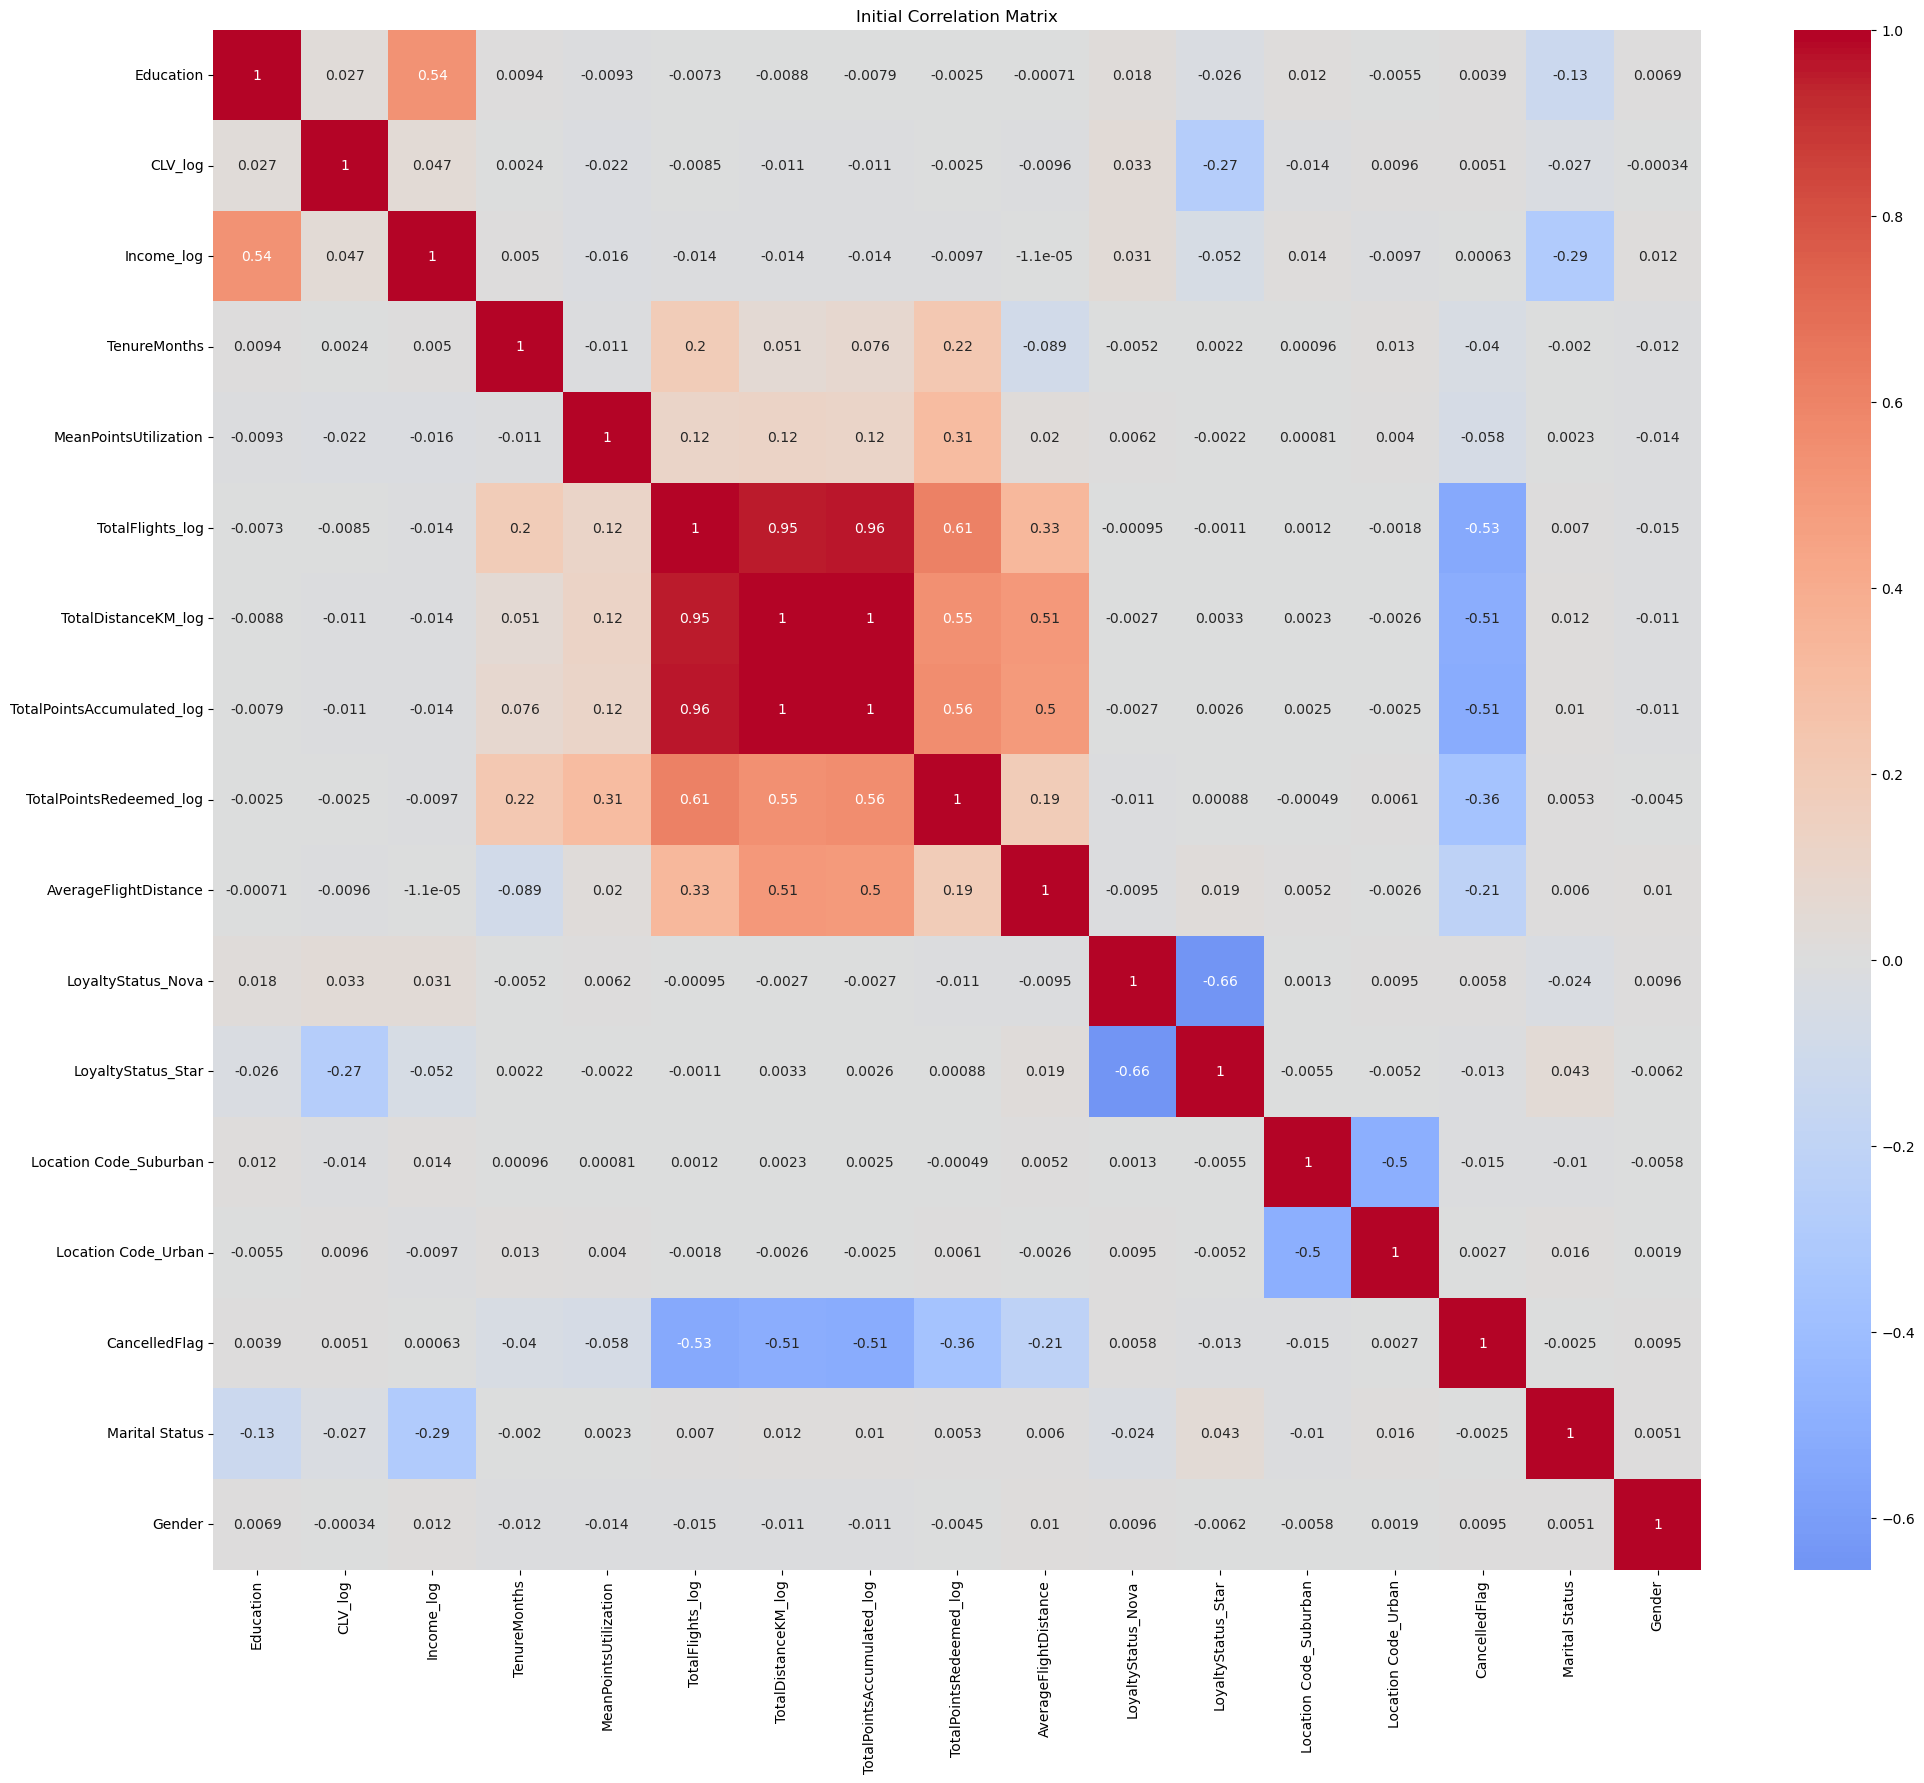

Dropping highly correlated features: ['TotalDistanceKM_log', 'TotalPointsAccumulated_log']
Updated behavior features: ['TotalFlights_log', 'TotalPointsRedeemed_log', 'MeanPointsUtilization', 'AverageFlightDistance']
Updated profile features: ['Income_log', 'Gender', 'Education', 'Marital Status', 'Location Code_Suburban', 'Location Code_Urban']


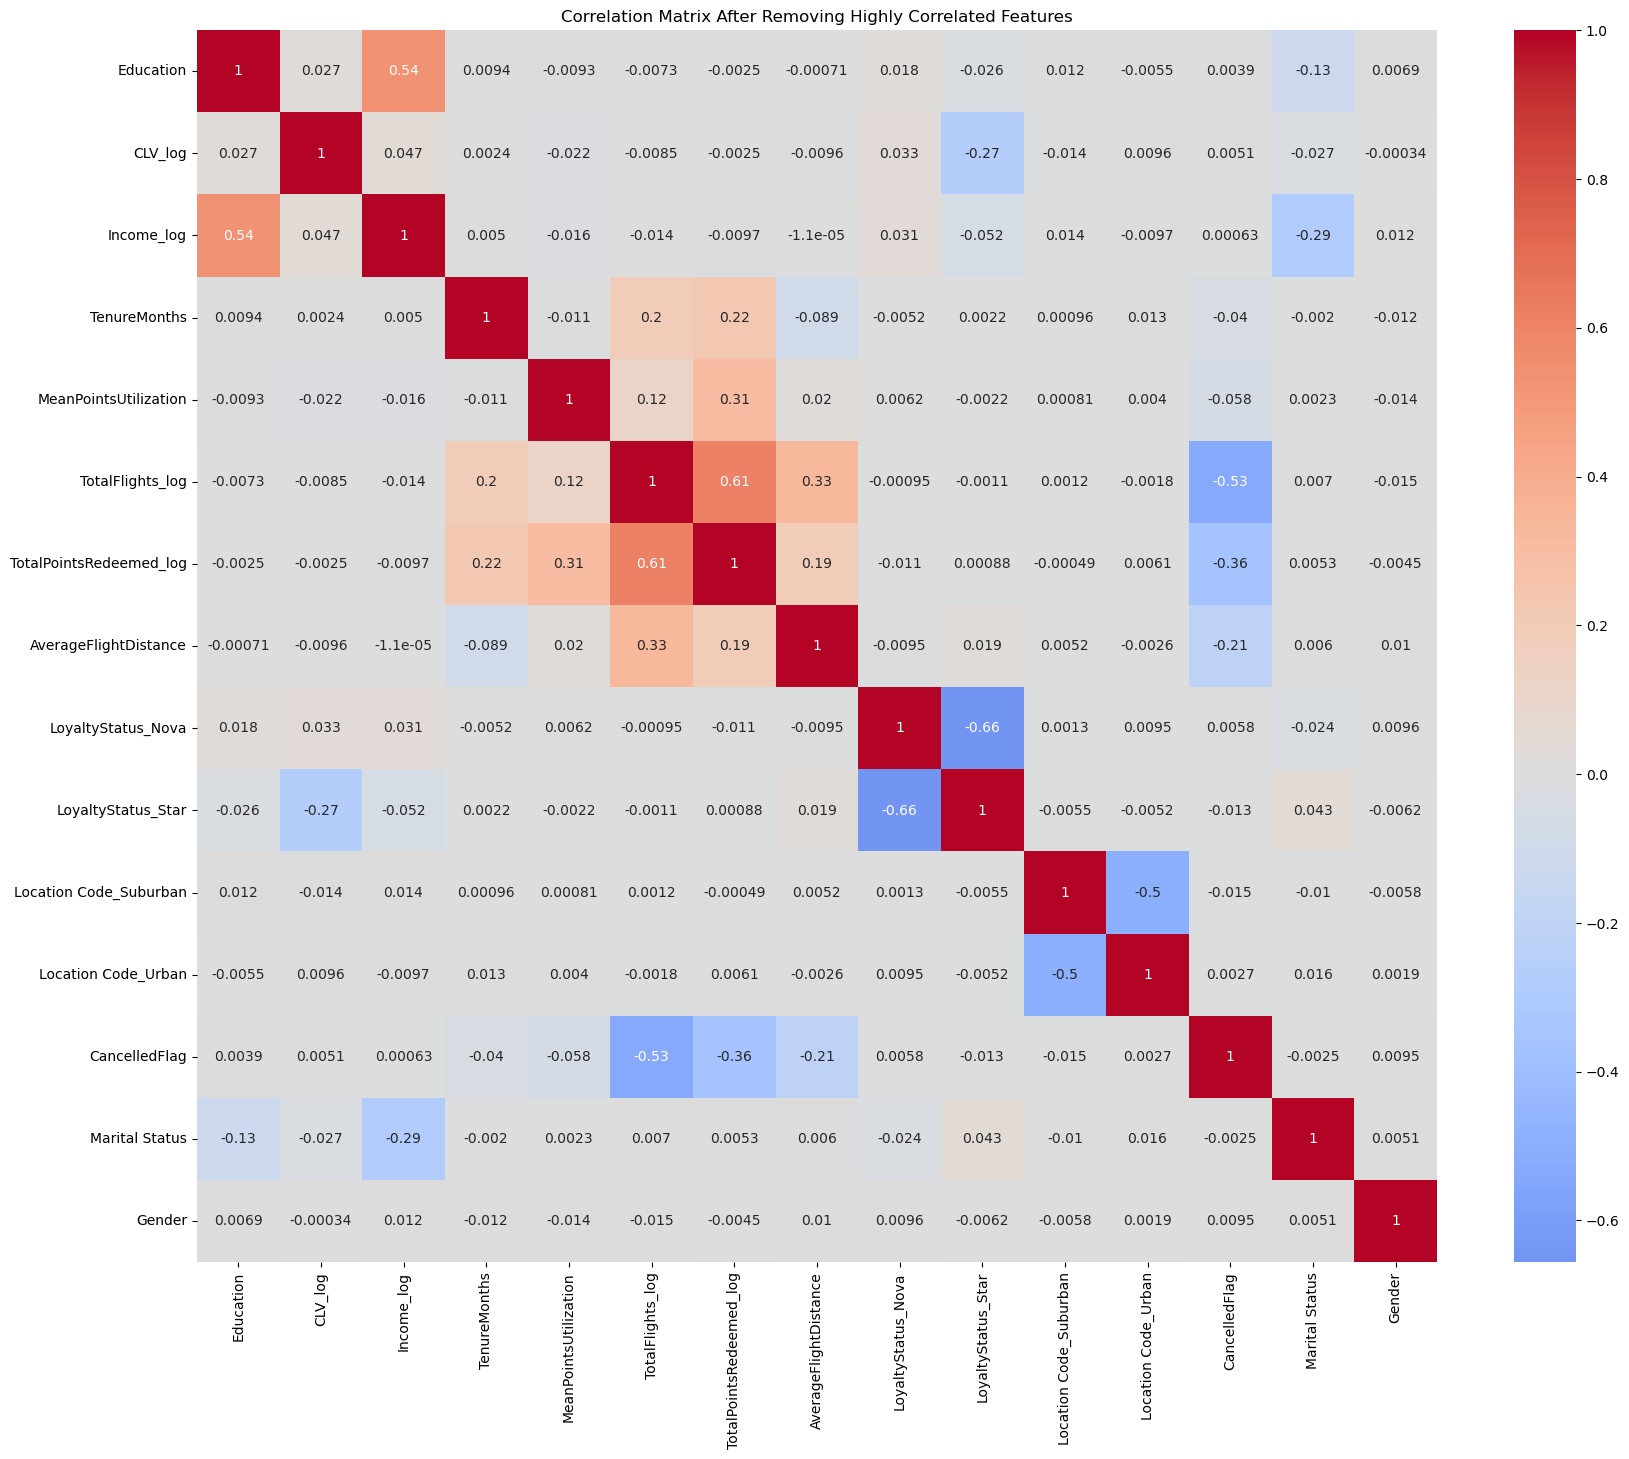

In [8]:
# Correlation Analysis and Feature Selection
# 1. Plot initial correlation matrix
plt.figure(figsize=(24, 20))
initial_corr = model_df.corr()
sns.heatmap(initial_corr, annot=True, cmap='coolwarm', center=0)
plt.title('Initial Correlation Matrix')
plt.show()

# 2. Identify and remove highly correlated features (> 0.8)
# We use the absolute correlation matrix
corr_matrix = model_df.corr().abs()

# We select the upper triangle of the correlation matrix. 
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# We drop the column (Feature B) if it has a correlation > 0.8 with any previous column (Feature A).
# This way, Feature A is kept and Feature B is removed.
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

print(f"Dropping highly correlated features: {to_drop}")

# Drop features from model_df
model_df = model_df.drop(columns=to_drop)

# Update feature lists to remove dropped columns
behavior_features = [f for f in behavior_features if f not in to_drop]
profile_features = [f for f in profile_features if f not in to_drop]

print(f"Updated behavior features: {behavior_features}")
print(f"Updated profile features: {profile_features}")

# 3. Plot updated correlation matrix
plt.figure(figsize=(20, 16))
sns.heatmap(model_df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix After Removing Highly Correlated Features')
plt.show()


# Outlier Detection

Detect and remove multivariate outliers using DBSCAN before clustering.

DBSCAN is applied to the scaled feature space for outlier detection. In this project, DBSCAN is used exclusively for identifying anomalous customers, not for final segmentation.

In [9]:
# Use model_df as X_scaled (Loyalty# is now the index)
dbscan = DBSCAN(eps=1.9, min_samples=20, n_jobs=1)
dbscan_labels = dbscan.fit_predict(model_df)

outlier_count = Counter(dbscan_labels)
print(f"DBSCAN results: {outlier_count}")
print(f"Outliers detected: {outlier_count.get(-1, 0)}")
print(f"Core customers: {outlier_count.get(0, 0)}")

core_mask = (dbscan_labels != -1)

model_df_clipped = model_df[core_mask]
outliers_df = model_df[dbscan_labels == -1]

print(f"Core customers kept: {len(model_df_clipped):,}")

DBSCAN results: Counter({np.int64(0): 11590, np.int64(1): 4144, np.int64(2): 656, np.int64(-1): 367})
Outliers detected: 367
Core customers: 11590
Core customers kept: 16,390


# Clustering Algorithms Comparison


## Clustering: Multiple Algorithms & Perspectives

We now test several clustering algorithms (KMeans, DBSCAN, MeanShift) with different hyperparameters, This approach allows us to compare cluster quality and interpretability across perspectives and methods.

In [10]:
# Prepare feature sets for clustering
behavior_df = model_df_clipped[behavior_features]
profile_df = model_df_clipped[profile_features]

In [11]:
# Apply dimensionality reduction techniques to visualize clusters
pca_be_df = apply_pca_2d(behavior_df)
pca_pr_df = apply_pca_2d(profile_df)

tsne_be_df = apply_tsne_2d(behavior_df)
tsne_pr_df = apply_tsne_2d(profile_df)

umap_be_df = apply_umap_2d(behavior_df)
umap_pr_df = apply_umap_2d(profile_df)


## K-means

In [12]:
# KMeans on behavior features
kmeans_param_grid = {'n_clusters': [2, 3, 4, 5, 6], 'init':['k-means++'], 'random_state':[42]}
kmeans_behavior_labels = evaluate_clustering(KMeans, behavior_df, kmeans_param_grid)
kmeans_behavior_labels.value_counts()

KMeans (n_clusters=2, init=k-means++, random_state=42): Clusters=2, Sil=0.59, DB=0.85, R2=0.52
KMeans (n_clusters=3, init=k-means++, random_state=42): Clusters=3, Sil=0.64, DB=0.51, R2=0.76
KMeans (n_clusters=4, init=k-means++, random_state=42): Clusters=4, Sil=0.61, DB=0.7, R2=0.78
KMeans (n_clusters=5, init=k-means++, random_state=42): Clusters=5, Sil=0.6, DB=0.77, R2=0.85
KMeans (n_clusters=6, init=k-means++, random_state=42): Clusters=6, Sil=0.59, DB=0.73, R2=0.87


KMeans_labels
1    11346
0     3491
2     1553
Name: count, dtype: int64

In [13]:
kmeans_profile_labels = evaluate_clustering(KMeans, profile_df, kmeans_param_grid)
kmeans_profile_labels.value_counts()

KMeans (n_clusters=2, init=k-means++, random_state=42): Clusters=2, Sil=0.49, DB=0.9, R2=0.47
KMeans (n_clusters=3, init=k-means++, random_state=42): Clusters=3, Sil=0.33, DB=1.47, R2=0.54
KMeans (n_clusters=4, init=k-means++, random_state=42): Clusters=4, Sil=0.36, DB=1.14, R2=0.65
KMeans (n_clusters=5, init=k-means++, random_state=42): Clusters=5, Sil=0.37, DB=1.22, R2=0.69
KMeans (n_clusters=6, init=k-means++, random_state=42): Clusters=6, Sil=0.43, DB=1.07, R2=0.77


KMeans_labels
0    11532
1     4858
Name: count, dtype: int64

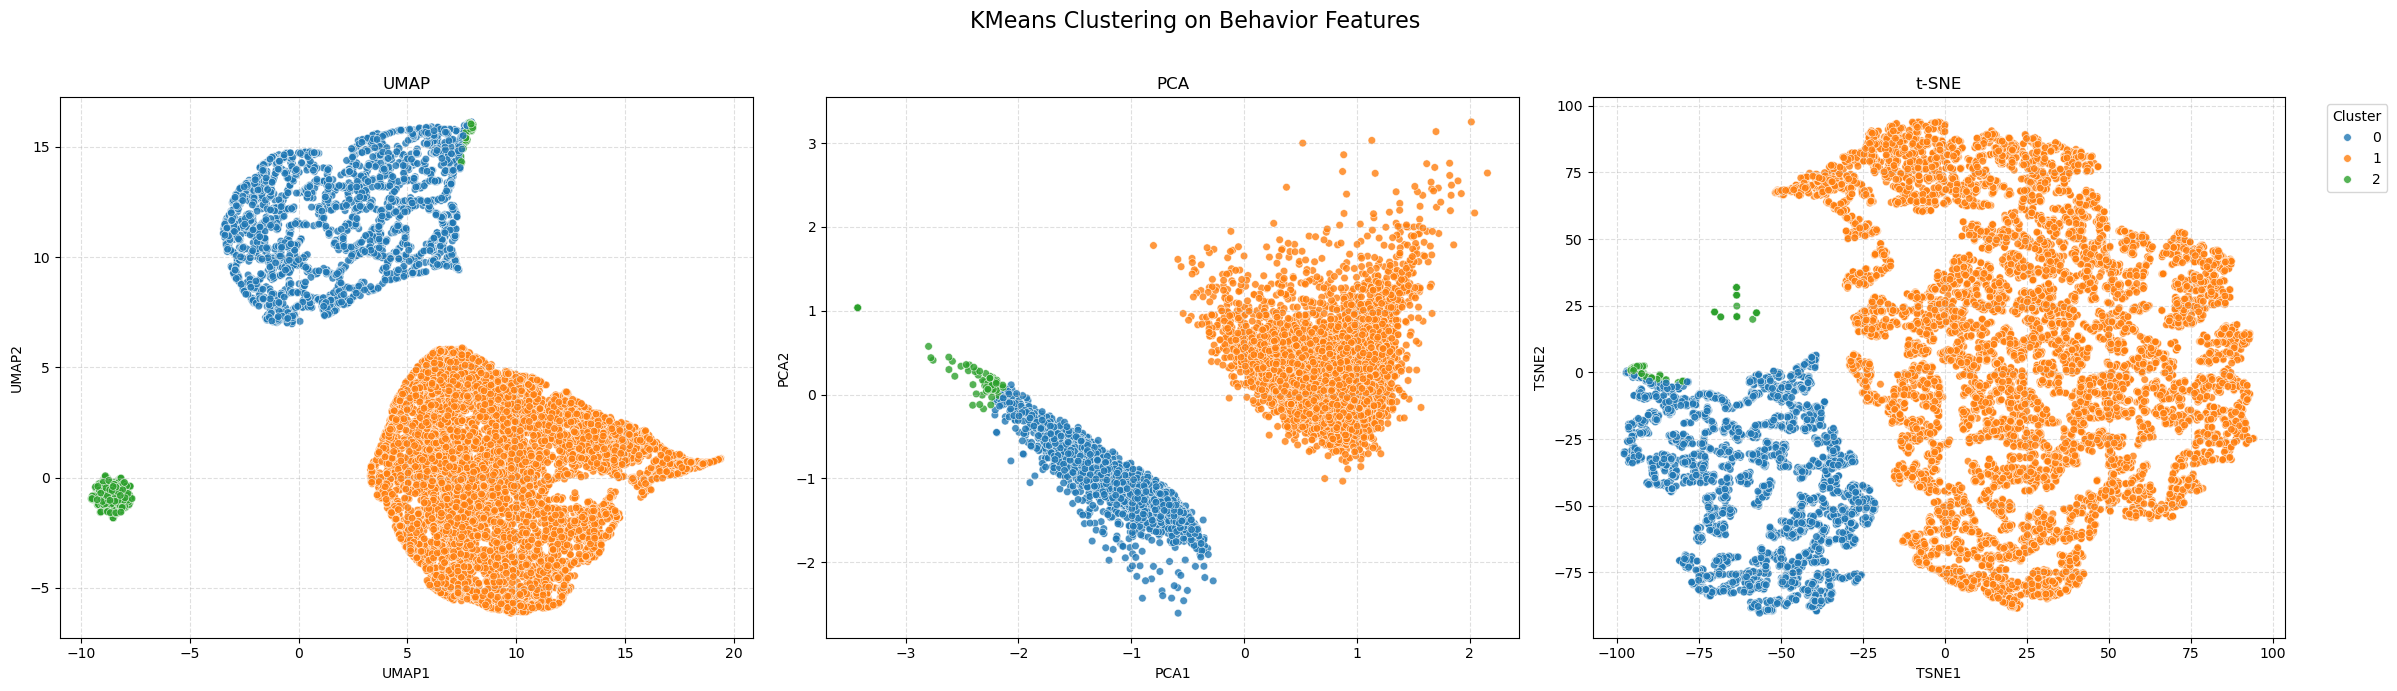

In [14]:
plot_cluster(
    umap_be_df, pca_be_df, tsne_be_df, kmeans_behavior_labels,
    main_title="KMeans Clustering on Behavior Features")

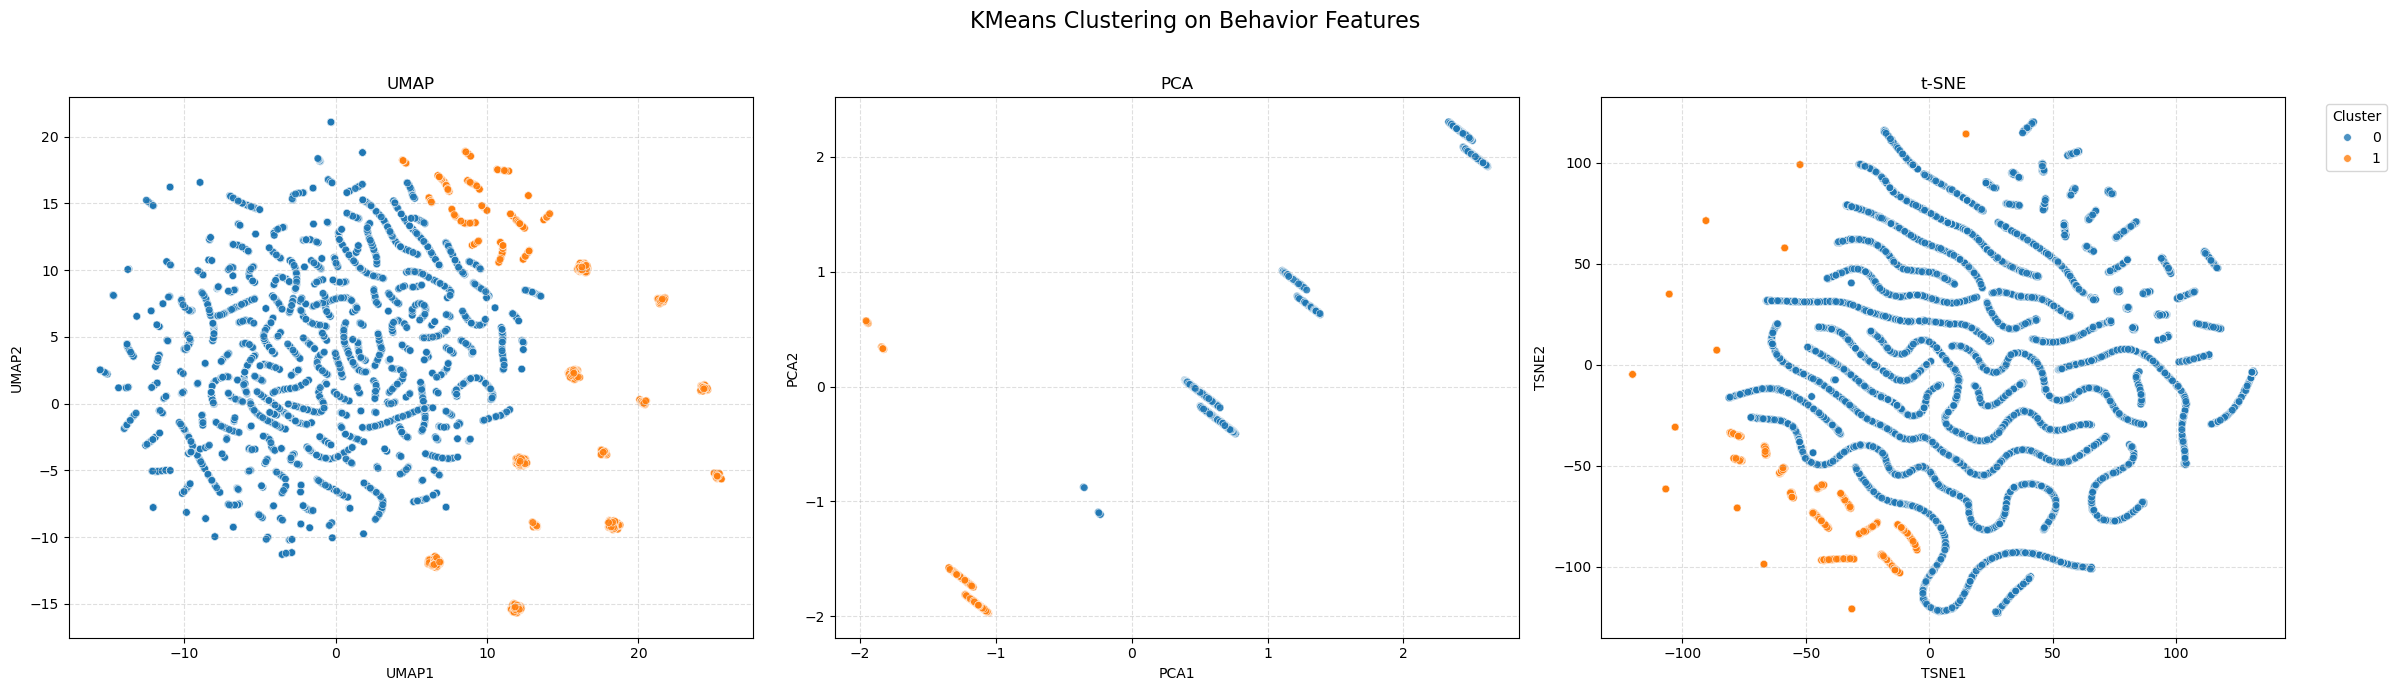

In [15]:
plot_cluster(
    umap_pr_df, pca_pr_df, tsne_pr_df, kmeans_profile_labels,
    main_title="KMeans Clustering on Behavior Features")

## Meanshift

In [16]:
# MeanShift on behavior features
bandwidth = estimate_bandwidth(behavior_df, quantile=0.2, n_samples=500)
meanshift_param_grid = {'bandwidth': [bandwidth], 'n_jobs': [-1]}
meanshift_behavior_labels = evaluate_clustering(MeanShift, behavior_df, meanshift_param_grid)
meanshift_behavior_labels.value_counts()

MeanShift (bandwidth=1.0499107315106098, n_jobs=-1): Clusters=3, Sil=0.64, DB=0.51, R2=0.76


MeanShift_labels
0    11346
1     3484
2     1560
Name: count, dtype: int64

In [17]:
# MeanShift on profile features
bandwidth = estimate_bandwidth(profile_df, quantile=0.2, n_samples=500)
meanshift_param_grid = {'bandwidth': [bandwidth], 'n_jobs': [-1]}
meanshift_profile_labels = evaluate_clustering(MeanShift, profile_df, meanshift_param_grid)
meanshift_profile_labels.value_counts()

MeanShift (bandwidth=1.4017917941867766, n_jobs=-1): Clusters=4, Sil=0.53, DB=0.76, R2=0.67


MeanShift_labels
0    10856
1     4144
2      720
3      670
Name: count, dtype: int64

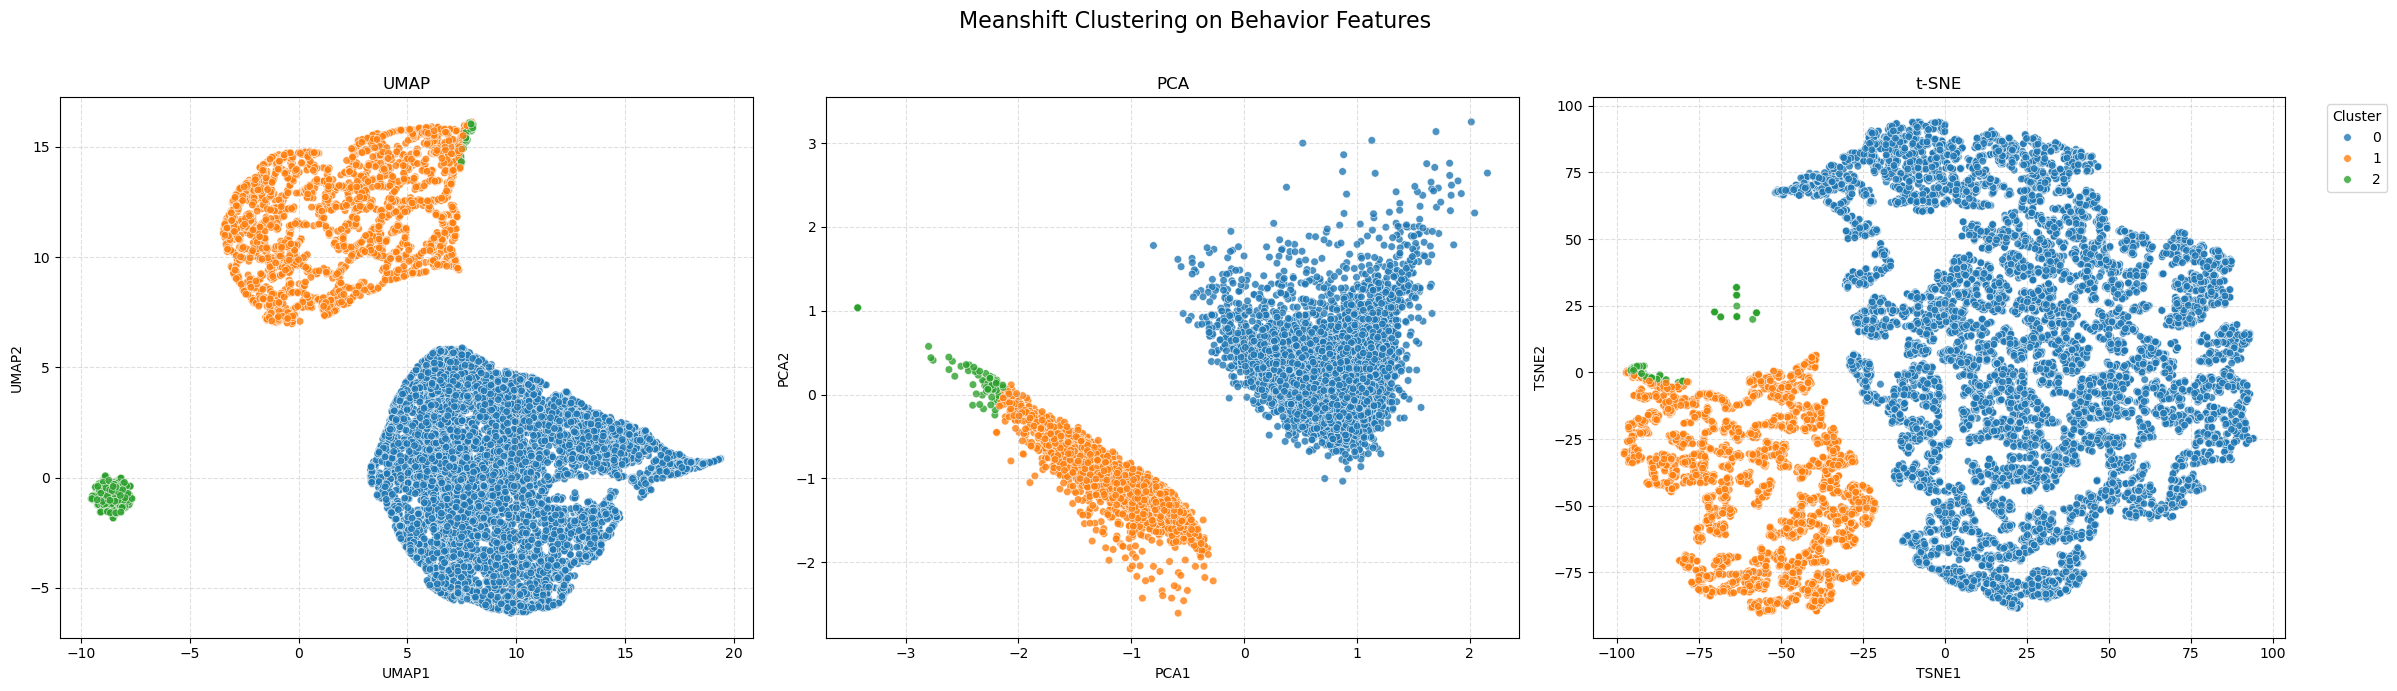

In [18]:
plot_cluster(
    umap_be_df, pca_be_df, tsne_be_df, meanshift_behavior_labels,
    main_title="Meanshift Clustering on Behavior Features")

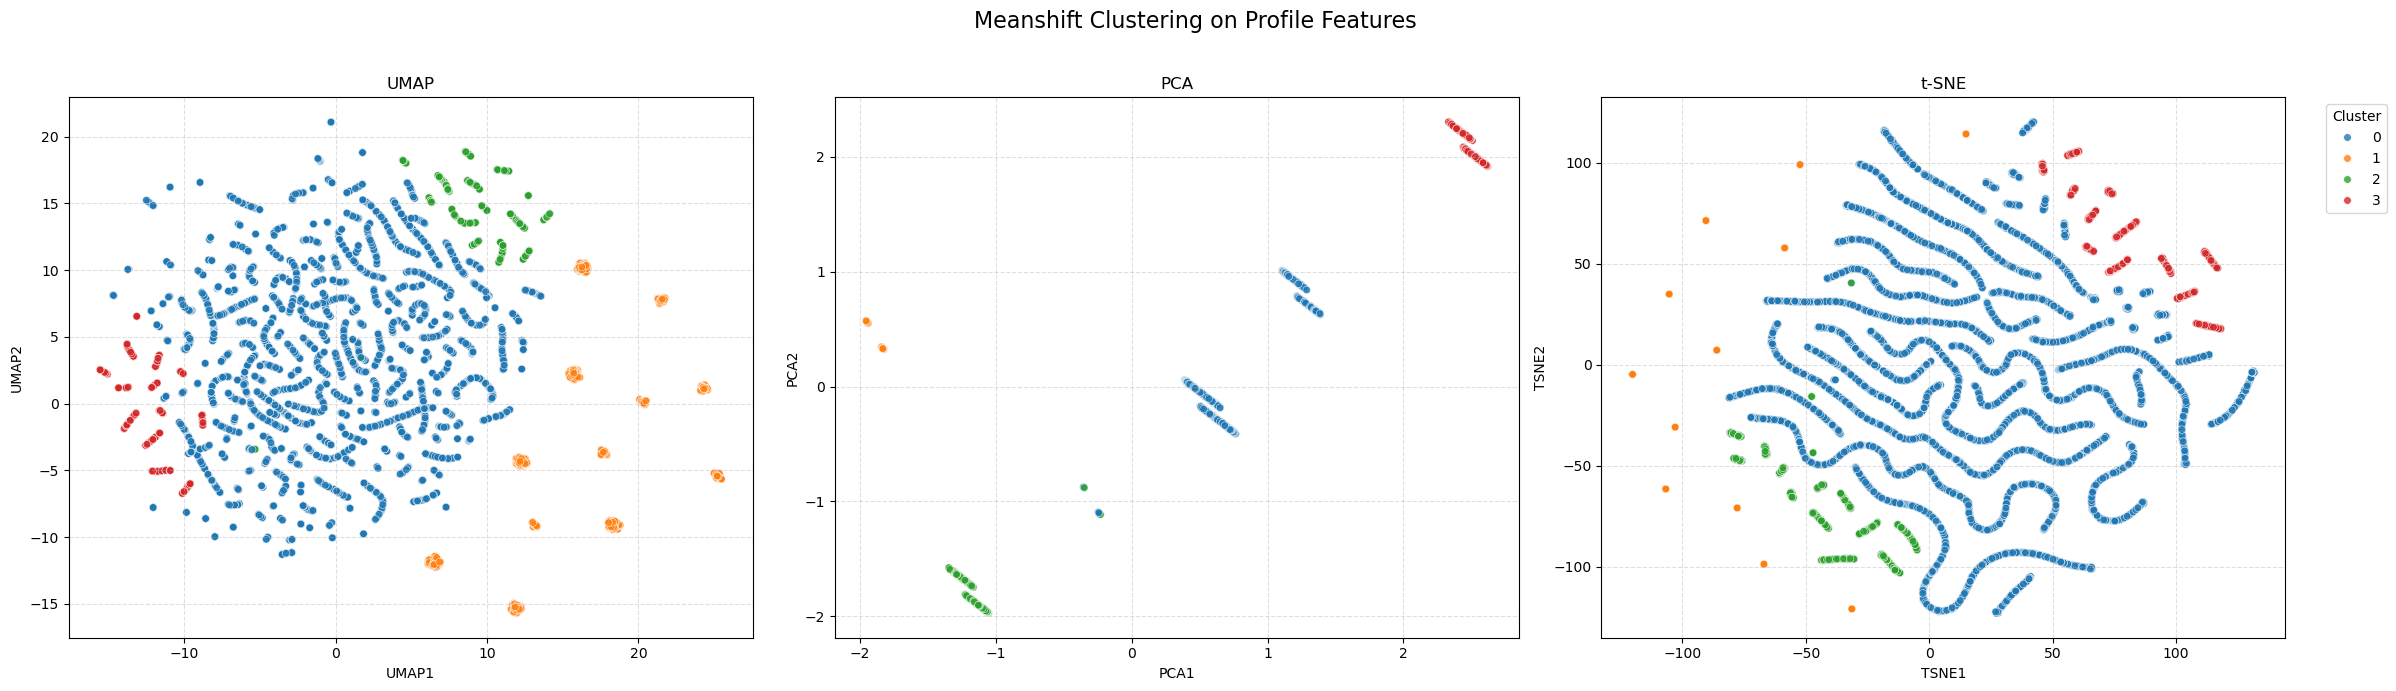

In [19]:
plot_cluster(
    umap_pr_df, pca_pr_df, tsne_pr_df,meanshift_profile_labels,
    main_title="Meanshift Clustering on Profile Features")

## DBSCAN

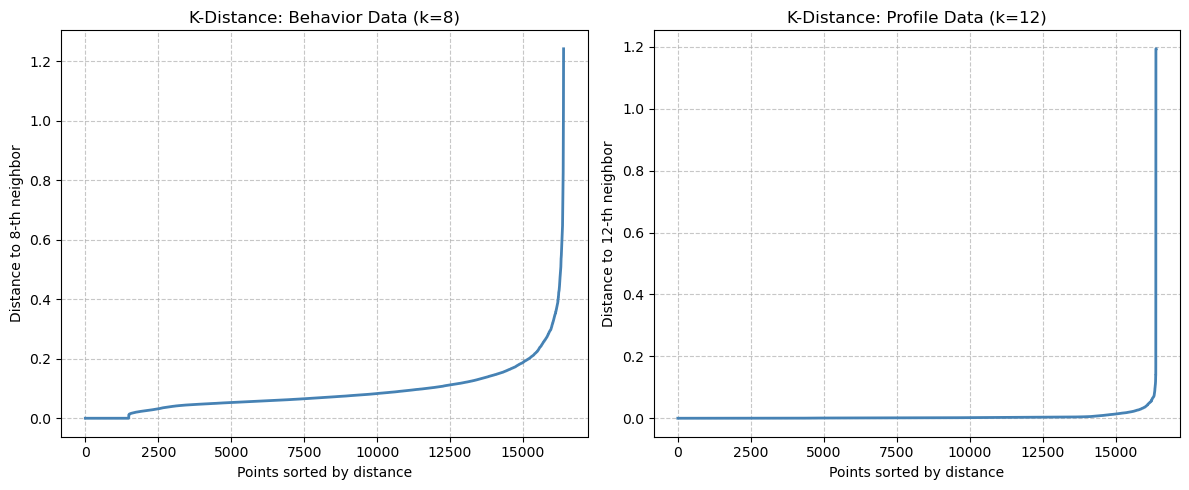

In [20]:
# Create two separate figures
plt.figure(figsize=(12, 5))

# Subplot 1: Behavior DataFrame
ax1 = plt.subplot(1, 2, 1)
plot_k_distance(behavior_df, "Behavior Data", ax=ax1)

# Subplot 2: Profile DataFrame
ax2 = plt.subplot(1, 2, 2)
plot_k_distance(profile_df, "Profile Data", ax=ax2)

plt.tight_layout()
plt.show()


In [21]:
# DBSCAN on profile features
dbscan_param_grid = {'eps': [0.2, 0.3, 0.4], 'min_samples': [10, 15, 20], 'n_jobs': [-1]}
dbscan_behavior_labels = evaluate_clustering(DBSCAN, behavior_df, dbscan_param_grid)
dbscan_behavior_labels.value_counts()    

DBSCAN (eps=0.2, min_samples=10, n_jobs=-1): Clusters=9, Sil=0.36, DB=1.24, R2=0.79
DBSCAN (eps=0.2, min_samples=15, n_jobs=-1): Clusters=5, Sil=0.59, DB=1.01, R2=0.79
DBSCAN (eps=0.2, min_samples=20, n_jobs=-1): Clusters=4, Sil=0.6, DB=1.17, R2=0.78
DBSCAN (eps=0.3, min_samples=10, n_jobs=-1): Clusters=5, Sil=0.63, DB=0.93, R2=0.78
DBSCAN (eps=0.3, min_samples=15, n_jobs=-1): Clusters=5, Sil=0.63, DB=0.97, R2=0.78
DBSCAN (eps=0.3, min_samples=20, n_jobs=-1): Clusters=4, Sil=0.64, DB=1.08, R2=0.78
DBSCAN (eps=0.4, min_samples=10, n_jobs=-1): Clusters=5, Sil=0.64, DB=0.86, R2=0.78
DBSCAN (eps=0.4, min_samples=15, n_jobs=-1): Clusters=4, Sil=0.64, DB=1.05, R2=0.77
DBSCAN (eps=0.4, min_samples=20, n_jobs=-1): Clusters=5, Sil=0.63, DB=1.0, R2=0.78


DBSCAN_labels
 0    11240
 1     3529
 2     1487
-1      126
 3        8
Name: count, dtype: int64

In [22]:
# DBSCAN on profile features
dbscan_param_grid = {'eps': [0.1, 0.2, 0.3], 'min_samples': [200, 350, 500], 'n_jobs': [-1]}
dbscan_profile_labels = evaluate_clustering(DBSCAN, profile_df, dbscan_param_grid)
dbscan_profile_labels.value_counts()   

DBSCAN (eps=0.1, min_samples=200, n_jobs=-1): Clusters=25, Sil=0.79, DB=1.61, R2=0.74
DBSCAN (eps=0.1, min_samples=350, n_jobs=-1): Clusters=19, Sil=0.61, DB=1.47, R2=0.58
DBSCAN (eps=0.1, min_samples=500, n_jobs=-1): Clusters=7, Sil=0.28, DB=1.21, R2=0.26
DBSCAN (eps=0.2, min_samples=200, n_jobs=-1): Clusters=25, Sil=0.79, DB=1.61, R2=0.74
DBSCAN (eps=0.2, min_samples=350, n_jobs=-1): Clusters=19, Sil=0.64, DB=1.48, R2=0.6
DBSCAN (eps=0.2, min_samples=500, n_jobs=-1): Clusters=13, Sil=0.58, DB=0.94, R2=0.46
DBSCAN (eps=0.3, min_samples=200, n_jobs=-1): Clusters=25, Sil=0.79, DB=1.61, R2=0.74
DBSCAN (eps=0.3, min_samples=350, n_jobs=-1): Clusters=19, Sil=0.64, DB=1.48, R2=0.6
DBSCAN (eps=0.3, min_samples=500, n_jobs=-1): Clusters=13, Sil=0.58, DB=0.94, R2=0.46


DBSCAN_labels
-1     1893
 7     1210
 16    1205
 4     1185
 5     1175
 20    1137
 0     1122
 15     597
 8      591
 19     560
 18     532
 14     524
 23     515
 6      473
 1      465
 9      458
 2      456
 3      452
 22     434
 12     247
 17     244
 10     239
 13     239
 21     228
 11     209
Name: count, dtype: int64

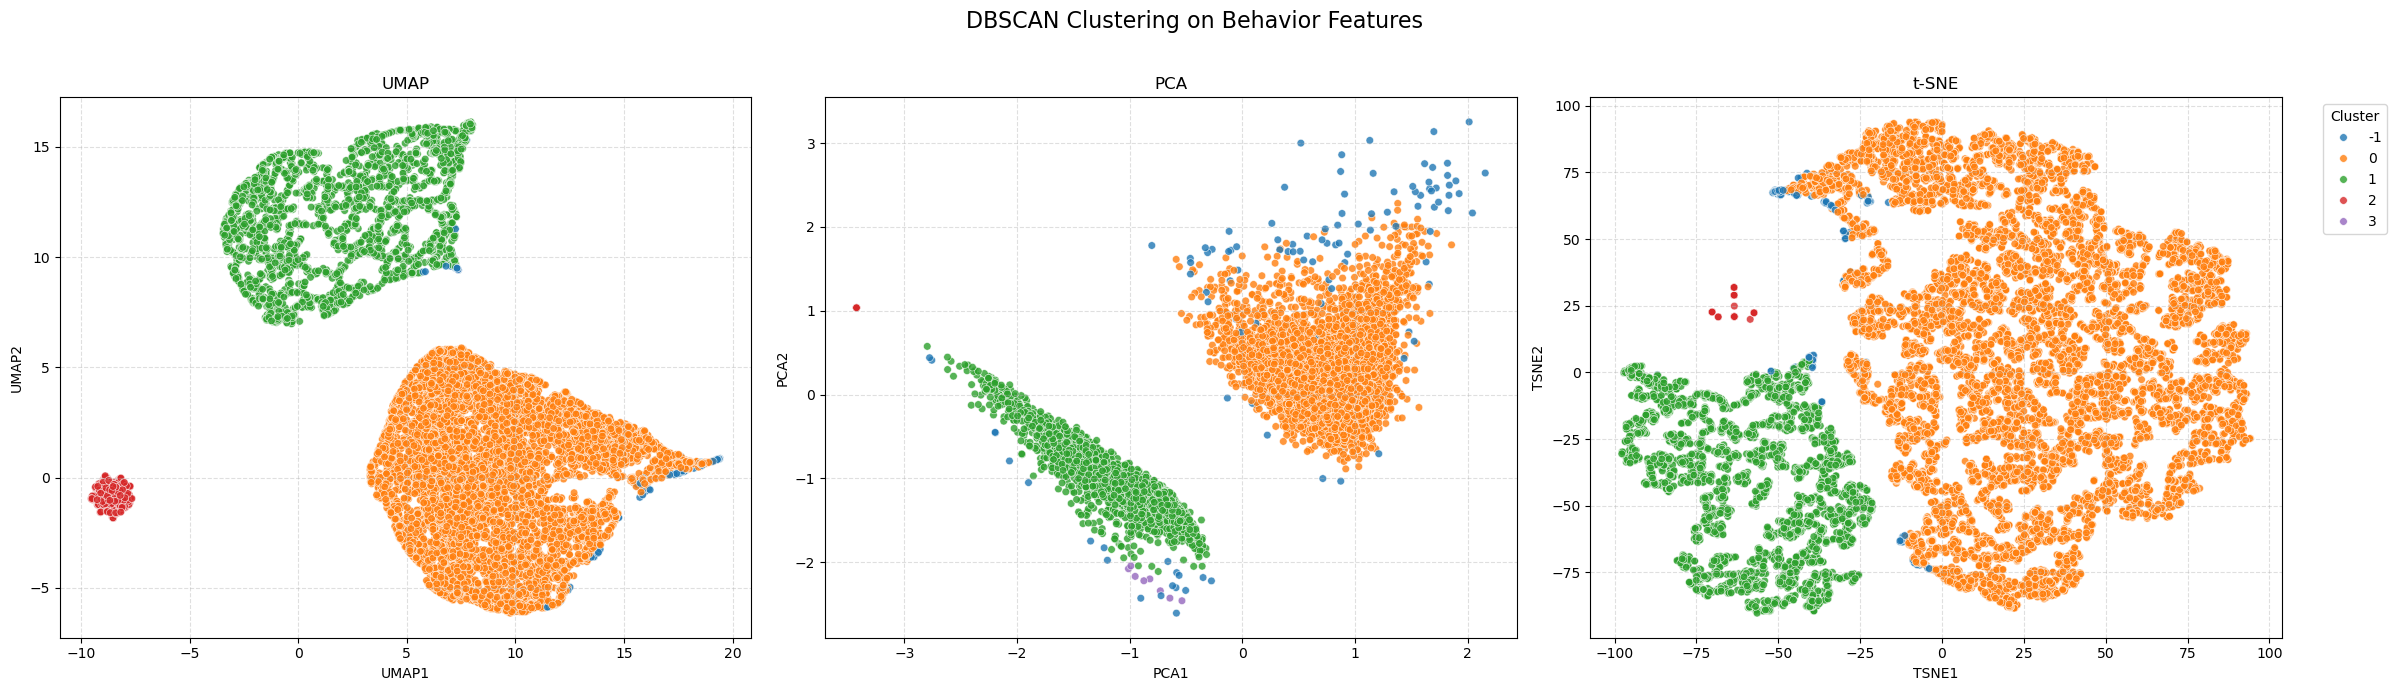

In [23]:
plot_cluster(
    umap_be_df, pca_be_df, tsne_be_df, dbscan_behavior_labels,
    main_title="DBSCAN Clustering on Behavior Features")

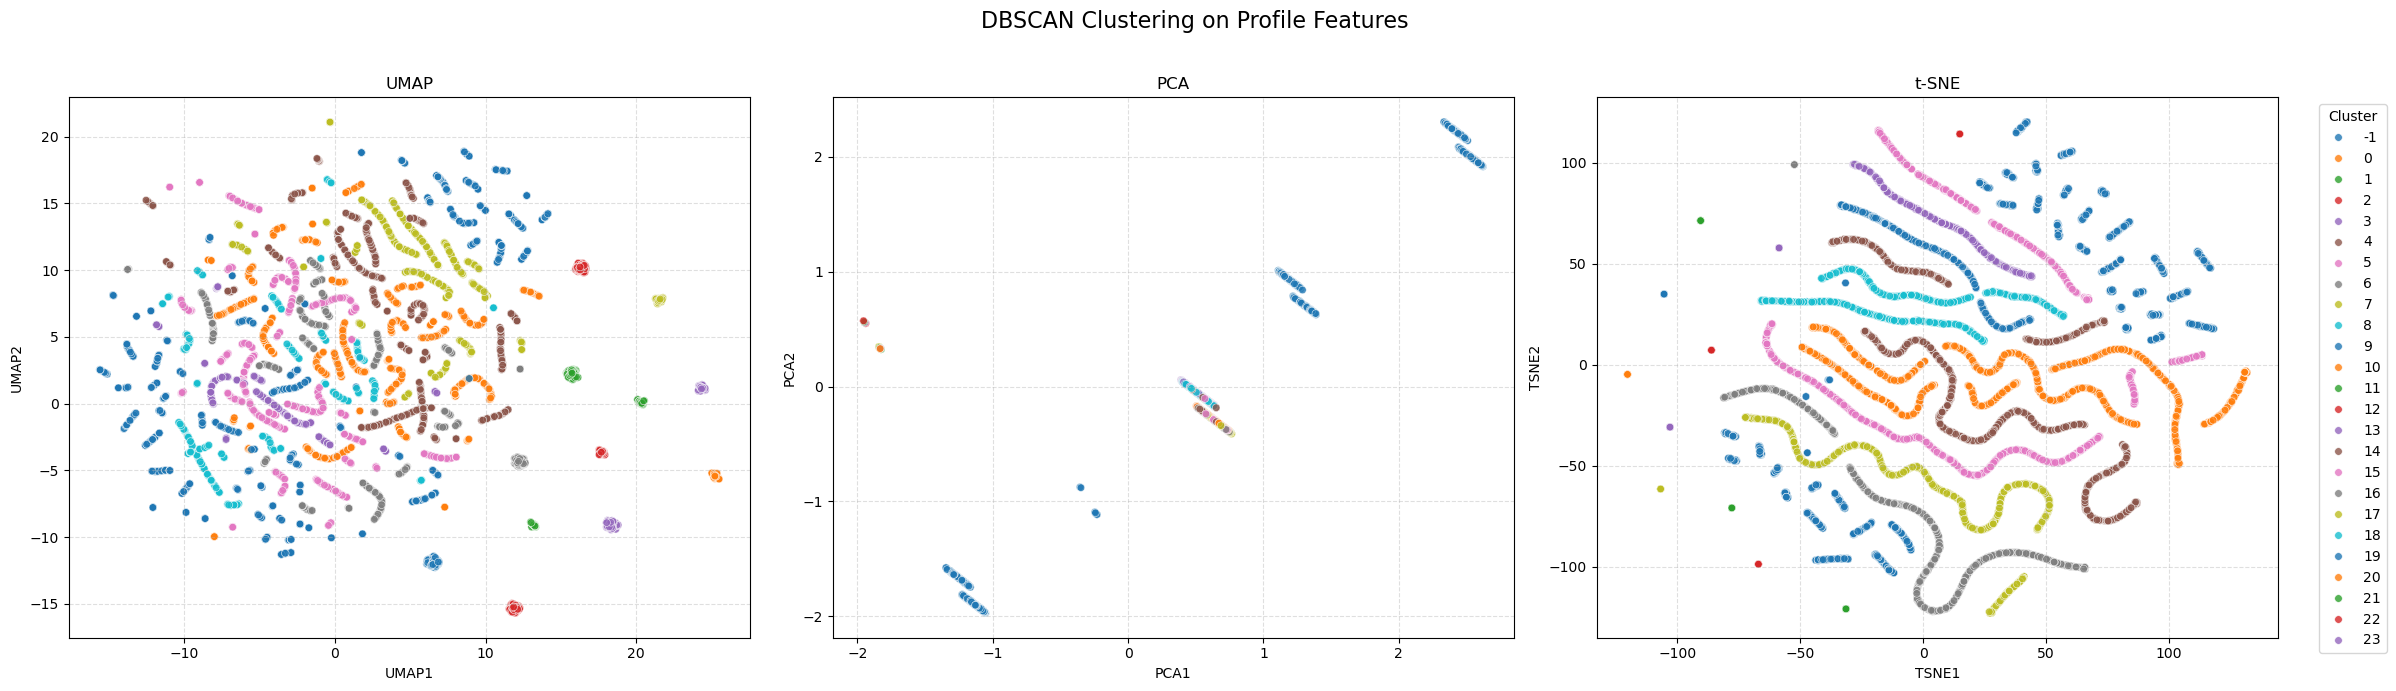

In [24]:
plot_cluster(
    umap_pr_df, pca_pr_df, tsne_pr_df, dbscan_profile_labels,
    main_title="DBSCAN Clustering on Profile Features")

# Self Organizing Maps

Simple workflow: train a SOM per perspective, cluster the SOM codebook with KMeans (use `evaluate_clustering`),
and map neuron clusters back to samples.

In [25]:
# Train SOM on behavior_df (using som_codebook_for_evaluation)
som_behavior, codebook_beh, bmu_series_beh = som_codebook_for_evaluation(behavior_df)

neuron_labels_beh = evaluate_clustering(KMeans, codebook_beh, verbose = False, param_grid=kmeans_param_grid)

som_labels_beh = bmu_series_beh.map(neuron_labels_beh)

# Calculate silhouette score for SOM clusters on behavior data
som_silhouette_beh = silhouette_score(behavior_df, som_labels_beh)
print(f"SOM Clustering on Behavior Data: Silhouette Score = {som_silhouette_beh:.2f}")

SOM Clustering on Behavior Data: Silhouette Score = 0.59


In [26]:
# Train SOM on behavior_df (using som_codebook_for_evaluation)
som_behavior, codebook_pro, bmu_series_pro = som_codebook_for_evaluation(profile_df)

neuron_labels_pro = evaluate_clustering(KMeans, codebook_pro, verbose=False, param_grid=kmeans_param_grid)

som_labels_pro = bmu_series_pro.map(neuron_labels_pro)

# Calculate silhouette score for SOM clusters on profile data
som_silhouette_pro = silhouette_score(profile_df, som_labels_pro)
print(f"SOM Clustering on Profile Data: Silhouette Score = {som_silhouette_pro:.2f}")

SOM Clustering on Profile Data: Silhouette Score = 0.51


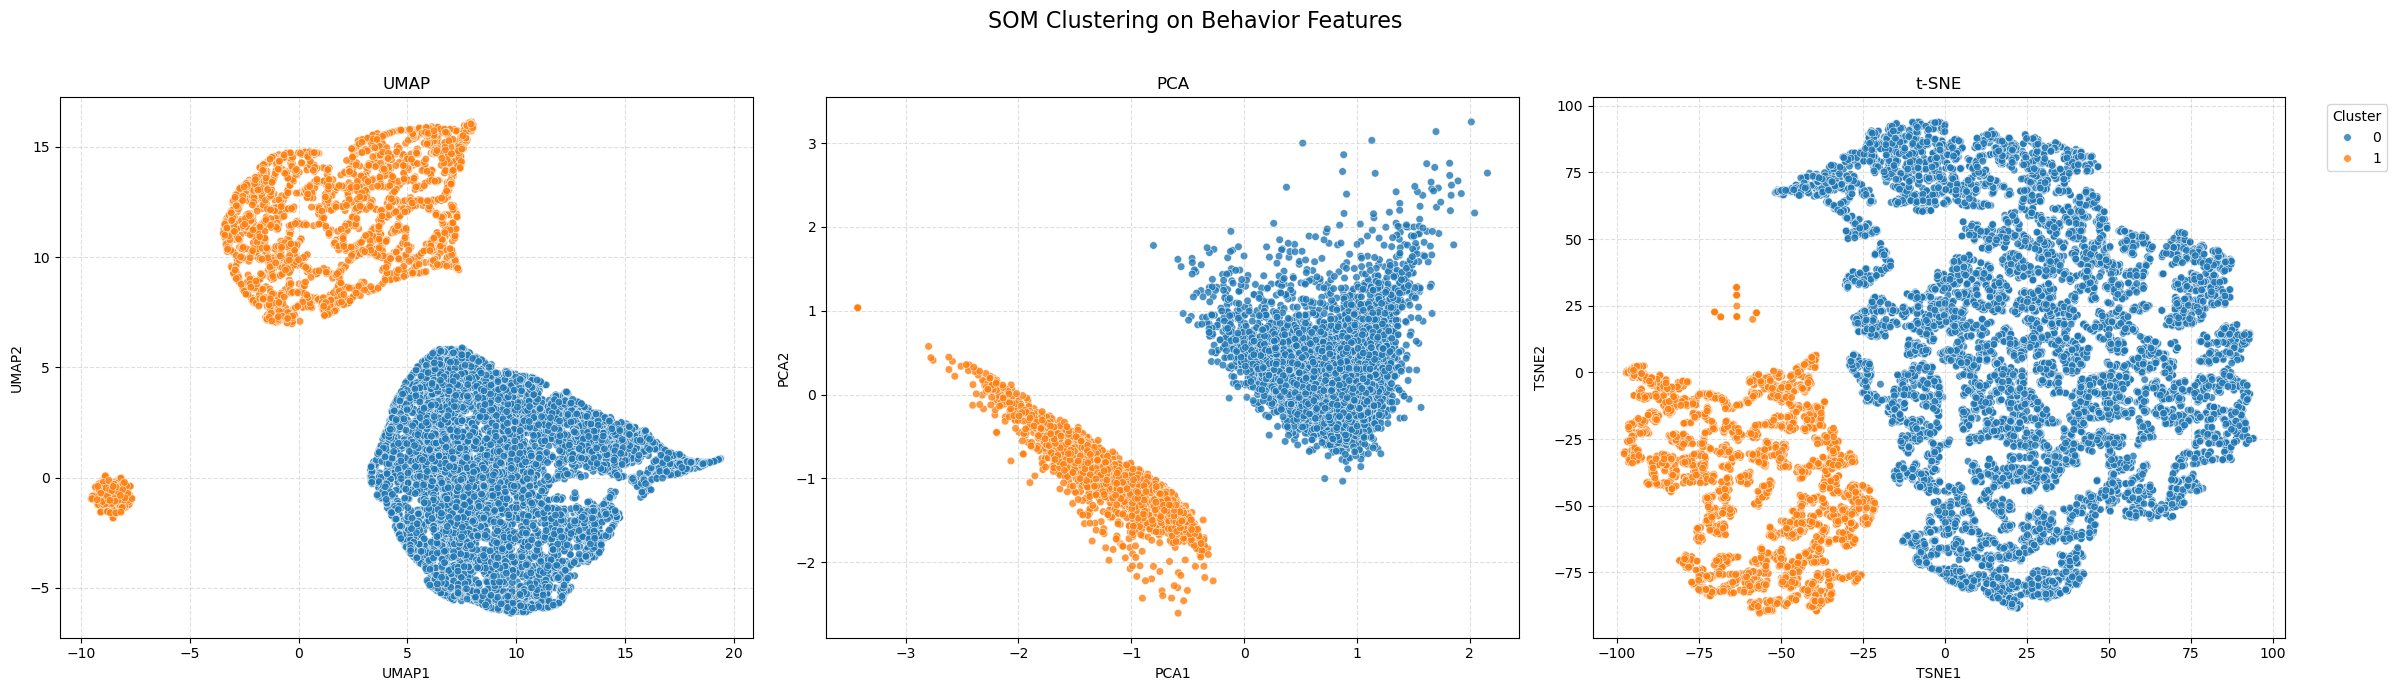

In [27]:
plot_cluster(
    umap_be_df, pca_be_df, tsne_be_df, som_labels_beh,
    main_title="SOM Clustering on Behavior Features")   


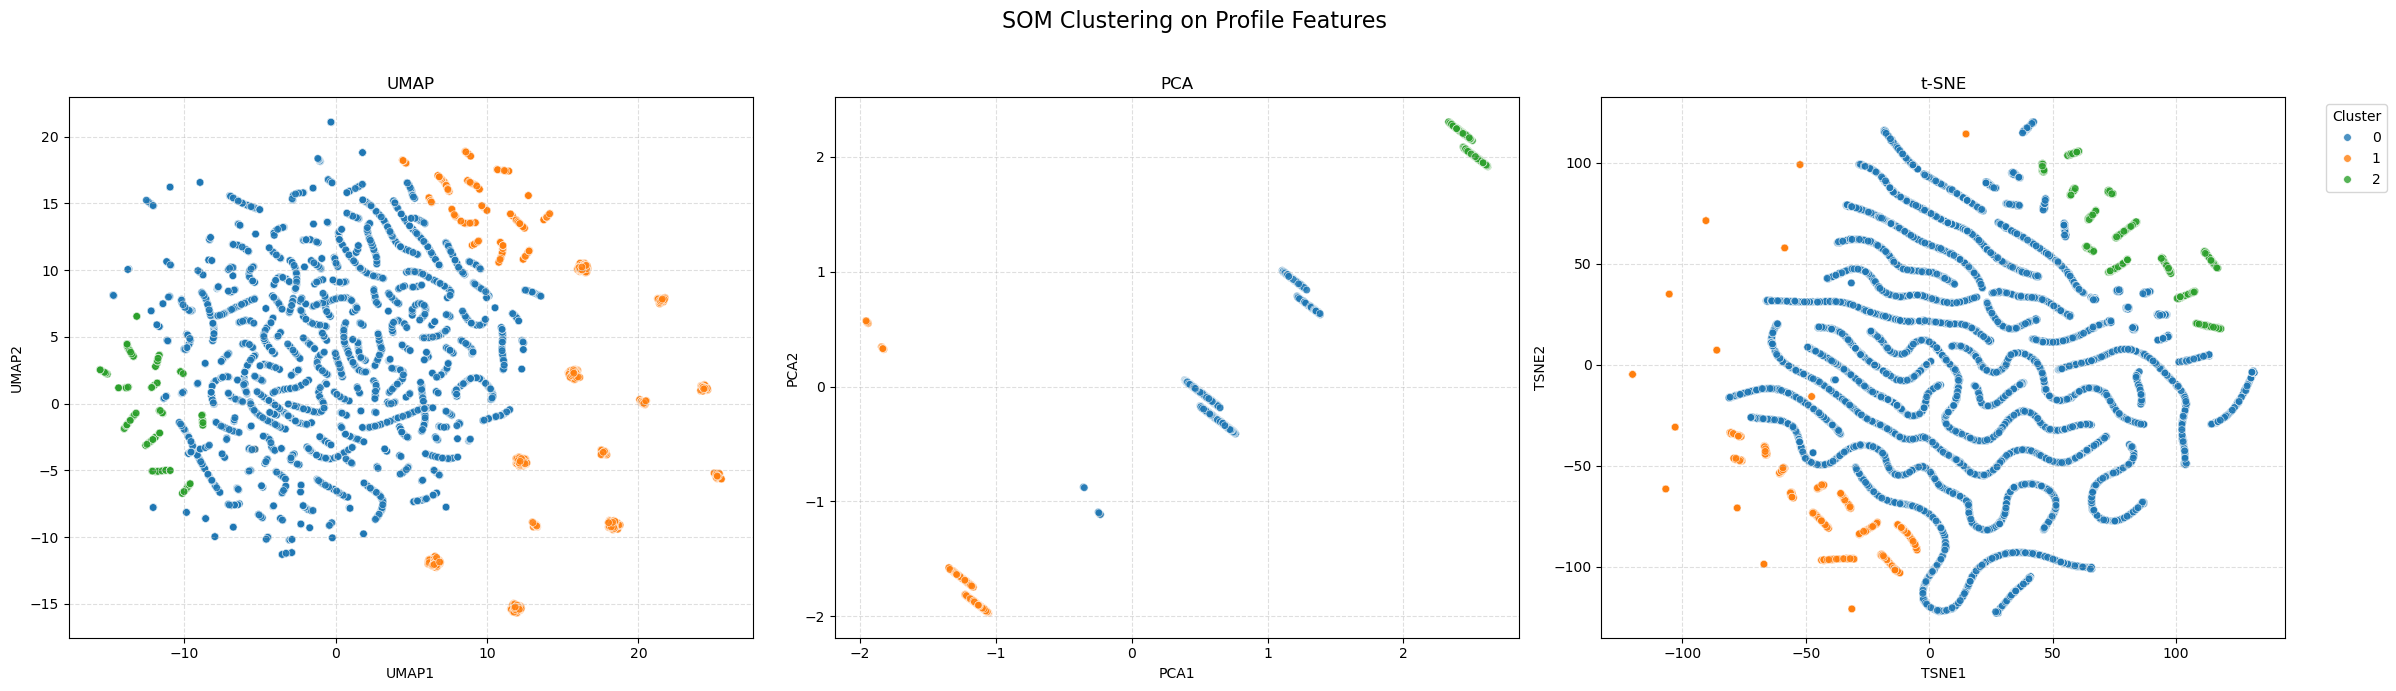

In [28]:
plot_cluster(
    umap_pr_df, pca_pr_df, tsne_pr_df, som_labels_pro,
    main_title="SOM Clustering on Profile Features")

# Fuzzy Clustering


In [41]:
try:
    import skfuzzy as fuzz
except ImportError:
    print("scikit-fuzzy not installed. Skipping Fuzzy C-Means clustering.")
    fuzz = None

if fuzz:
    print("--- Fuzzy C-Means in Behavior Features ---")
    data_behavior = behavior_df.T.values
    n_clusters_range = range(2, 7)
    
    for n_clusters in n_clusters_range:
        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
            data_behavior, n_clusters, 2, error=0.005, maxiter=1000, init=None, seed=42
        )
        
        hard_labels = np.argmax(u, axis=0)
        silhouette  = silhouette_score(behavior_df, hard_labels)
        
        print(f"Clusters: {n_clusters}, Silhuette: {silhouette:.3f}, FPC: {fpc:.3f}")

    print("\n" + "="*50 + "\n")
    print("--- Fuzzy C-Means in Profile Features ---")

    data_profile = profile_df.T.values
    
    for n_clusters in n_clusters_range:

        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
            data_profile, n_clusters, 2, error=0.005, maxiter=1000, init=None, seed=42
        )
        
        hard_labels = np.argmax(u, axis=0)
        silhouette = silhouette_score(profile_df, hard_labels)
        
        print(f"Clusters: {n_clusters}, Silhueta: {silhouette:.3f}, FPC: {fpc:.3f}")

--- Fuzzy C-Means in Behavior Features ---
Clusters: 2, Silhuette: 0.588, FPC: 0.820
Clusters: 3, Silhuette: 0.644, FPC: 0.830
Clusters: 4, Silhuette: 0.495, FPC: 0.677
Clusters: 5, Silhuette: 0.406, FPC: 0.604
Clusters: 6, Silhuette: 0.371, FPC: 0.582


--- Fuzzy C-Means in Profile Features ---
Clusters: 2, Silhueta: 0.494, FPC: 0.766
Clusters: 3, Silhueta: 0.300, FPC: 0.525
Clusters: 4, Silhueta: 0.308, FPC: 0.434
Clusters: 5, Silhueta: 0.249, FPC: 0.387
Clusters: 6, Silhueta: 0.261, FPC: 0.380


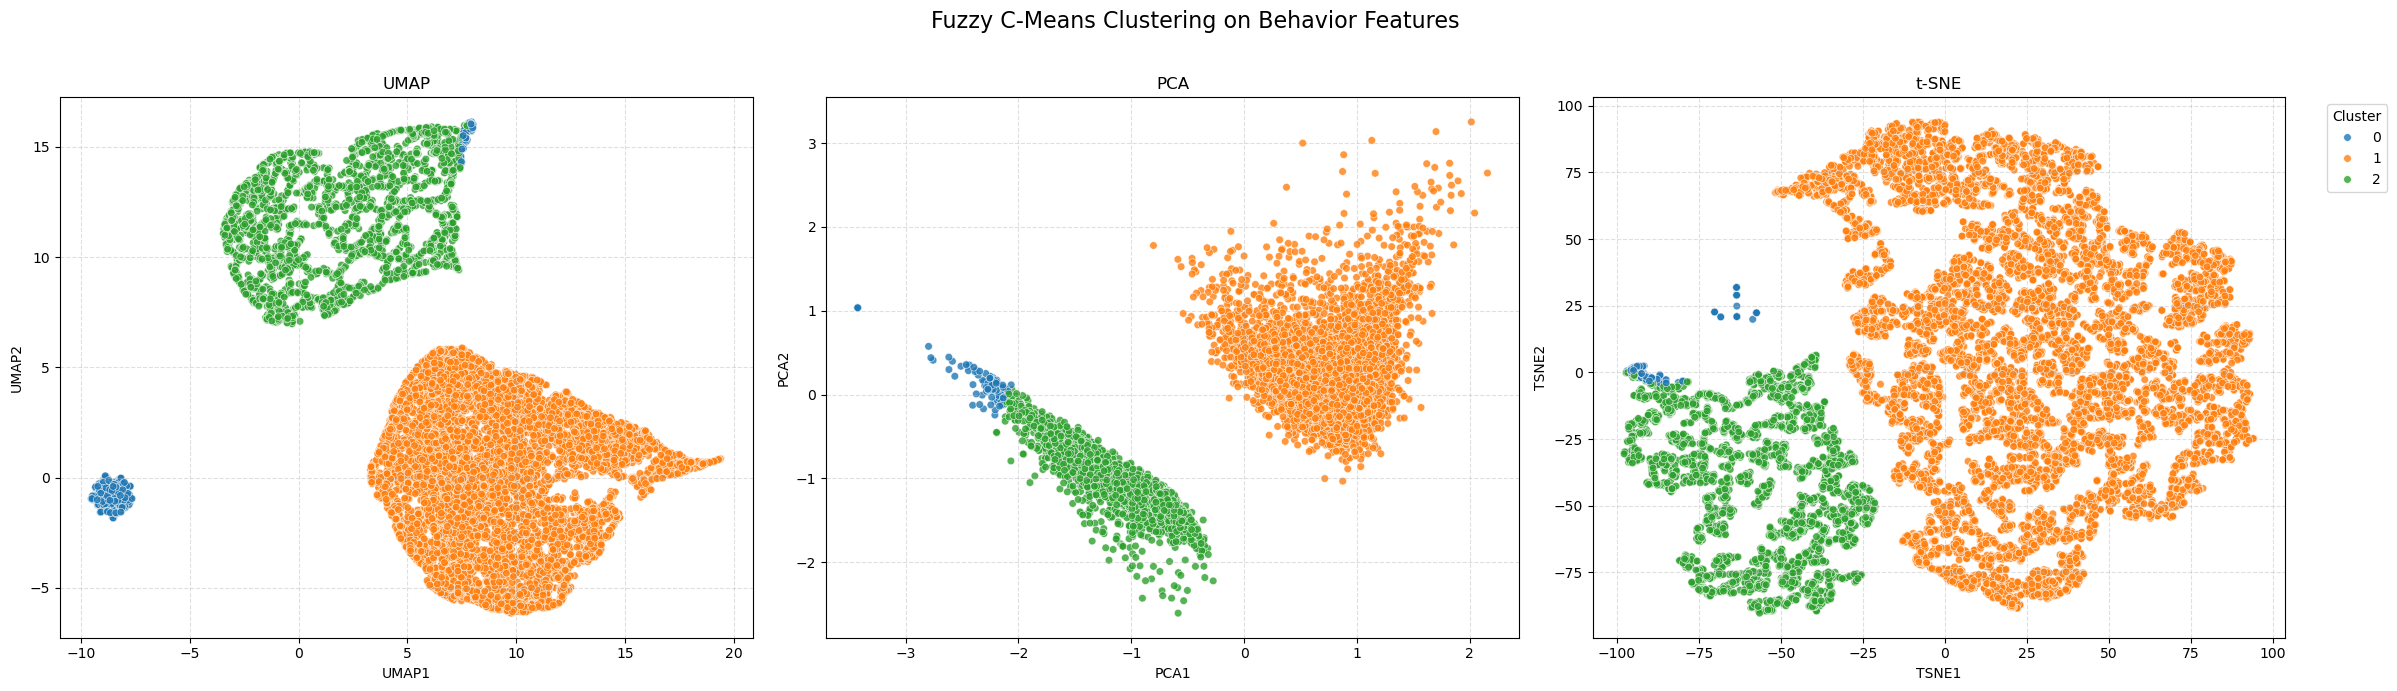

In [43]:
if fuzz:
    # --- Fuzzy C-Means Visualization for b. Features ---
    
    n_clusters_beh = 3 # Choosed based in silhouette score
    
    _, u_beh, _, _, _, _, _ = fuzz.cluster.cmeans(
        behavior_df.T.values, n_clusters_beh, 2, error=0.005, maxiter=1000, seed=42
    )
    
    hard_labels_beh = np.argmax(u_beh, axis=0)
    fuzzy_behavior_labels = pd.Series(hard_labels_beh, index=behavior_df.index, name="fuzzy_behavior_labels")

    plot_cluster(
        umap_be_df, pca_be_df, tsne_be_df,
        fuzzy_behavior_labels,
        main_title="Fuzzy C-Means Clustering on Behavior Features")

#### Fuzzy Clustering Conclusions (Behavior)

- **Optimal Clusters**: Based on the silhouette scores, **3 clusters** provide the best separation for the behavioral data.
- **Cluster Quality**: The Fuzzy Partition Coefficient (FPC) is moderate, indicating some overlap between clusters, which is expected with fuzzy clustering. The visualization confirms that while the clusters are centered in distinct regions, their boundaries are not sharply defined, reflecting the "fuzzy" nature of the assignments.


# Merge Cluster Solutions

After identifying the best clustering solutions for each perspective, merge them using hierarchical clustering on the centroids.

In [29]:
# Combine clustering results into final dataframe for analysis
combined_features = list(behavior_df.columns) + list(profile_df.columns)

# Create final dataframe with cluster labels
final_df = model_df_clipped[combined_features].copy()
final_df["behavior_cluster"] = meanshift_behavior_labels.reindex(final_df.index).astype(int)
final_df["profile_cluster"]  = meanshift_profile_labels.reindex(final_df.index).astype(int)

# Calculate centroids for each (behavior_cluster, profile_cluster) pair
df_centroids = final_df.groupby(["behavior_cluster", "profile_cluster"])[combined_features].mean()
df_centroids

TotalFlights_log  TotalPointsRedeemed_log  \
behavior_cluster profile_cluster                                              
0                0                        0.412840                 0.663939   
                 1                        0.411843                 0.666927   
                 2                        0.432534                 0.667603   
                 3                        0.436839                 0.667957   
1                0                       -0.067631                -1.479347   
                 1                       -0.019666                -1.479347   
                 2                        0.039245                -1.479347   
                 3                        0.071515                -1.479347   
2                0                       -2.718999                -1.479347   
                 1                       -2.712989                -1.479347   
                 2                       -2.745301                -1.479347   
                 3                       -2.735891                -1.479347   

                                  MeanPointsUtilization  \
behavior_cluster profile_cluster                          
0                0                             0.097856   
                 1                             0.081238   
                 2                             0.023718   
                 3                             0.073298   
1                0                            -0.429428   
                 1                            -0.429428   
                 2                            -0.429428   
                 3                            -0.429428   
2                0                            -0.429428   
                 1                            -0.429428   
                 2                            -0.429428   
                 3                            -0.429428   

                                  AverageFlightDistance  Income_log    Gender  \
behavior_cluster profile_cluster                                                
0                0                             0.123717    0.603713  0.501946   
                 1                             0.113130   -1.710038  0.494118   
                 2                             0.132509    0.401481  0.512720   
                 3                             0.128366    0.403204  0.520325   
1                0                             0.160545    0.603590  0.510457   
                 1                             0.142935   -1.710038  0.473982   
                 2                             0.009598    0.404830  0.527778   
                 3                             0.070499    0.395050  0.407080   
2                0                            -1.645912    0.599769  0.511321   
                 1                            -1.643211   -1.710038  0.524324   
                 2                            -1.653199    0.420001  0.569231   
                 3                            -1.661297    0.396588  0.600000   

                                  Education  Marital Status  \
behavior_cluster profile_cluster                              
0                0                 0.302280        0.331276   
                 1                -0.946877        0.669550   
                 2                -2.140769        0.344423   
                 3                 3.231744        0.359756   
1                0                 0.302556        0.335894   
                 1                -0.946877        0.649321   
                 2                -2.140769        0.312500   
                 3                 3.231744        0.424779   
2                0                 0.293193        0.337736   
                 1                -0.946877        0.618919   
                 2                -2.030564        0.246154   
                 3                 3.231744        0.384615   

                                  Location Code_Suburban  Location Code_Urban  
be

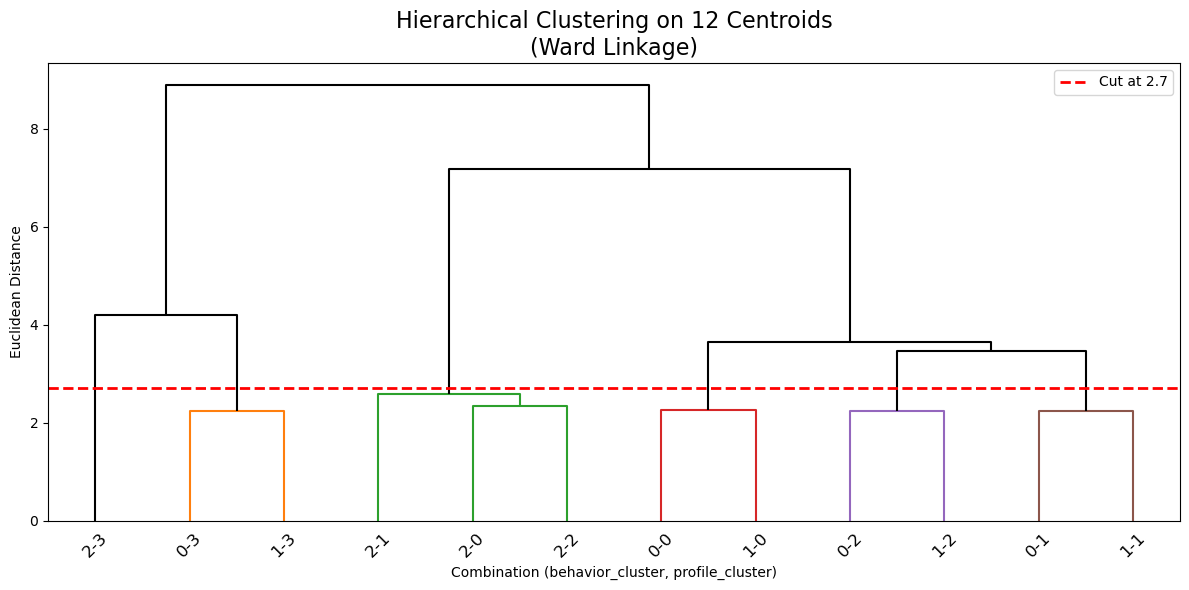

In [30]:
# Dendrogram of Centroids using Hierarchical Clustering
fig = plt.figure(figsize=(12, 6))

X_centroids = df_centroids[combined_features].values  # matriz (n_centroids x n_features)

# Hierarchical Clustering with Ward linkage
hclust = AgglomerativeClustering(
    linkage="ward",
    metric="euclidean",
    distance_threshold=0,
    n_clusters=None
)

hclust_labels = hclust.fit_predict(X_centroids)

counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

for i, merge in enumerate(hclust.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([
    hclust.children_,
    hclust.distances_,
    counts
]).astype(float)

y_threshold = 2.7

labels = [
    f"{idx[0]}-{idx[1]} (n={int(df_centroids.loc[idx, 'segment_size'])})"
    if "segment_size" in df_centroids.columns
    else f"{idx[0]}-{idx[1]}"
    for idx in df_centroids.index
]

dendrogram(
    linkage_matrix,
    labels=labels,
    color_threshold=y_threshold,
    above_threshold_color="k"
)

plt.axhline(
    y=y_threshold,
    color="r",
    linestyle="--",
    linewidth=2,
    label=f"Cut at {y_threshold}"
)

plt.title(
    f"Hierarchical Clustering on {len(df_centroids)} Centroids\n(Ward Linkage)",
    fontsize=16
)
plt.xlabel("Combination (behavior_cluster, profile_cluster)")
plt.ylabel("Euclidean Distance")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [31]:
# Final cluster based on dendrogram cut
n_final_clusters = 6

hclust_final = AgglomerativeClustering(
    linkage='ward',
    n_clusters=n_final_clusters,
)

hclust_final_labels = hclust_final.fit_predict(df_centroids)

df_centroids['merged_labels'] = hclust_final_labels

cluster_mapper = df_centroids['merged_labels'].to_dict()

final_df['merged_labels'] = final_df.apply(
    lambda row: cluster_mapper[(row['behavior_cluster'], row['profile_cluster'])],
    axis=1
)

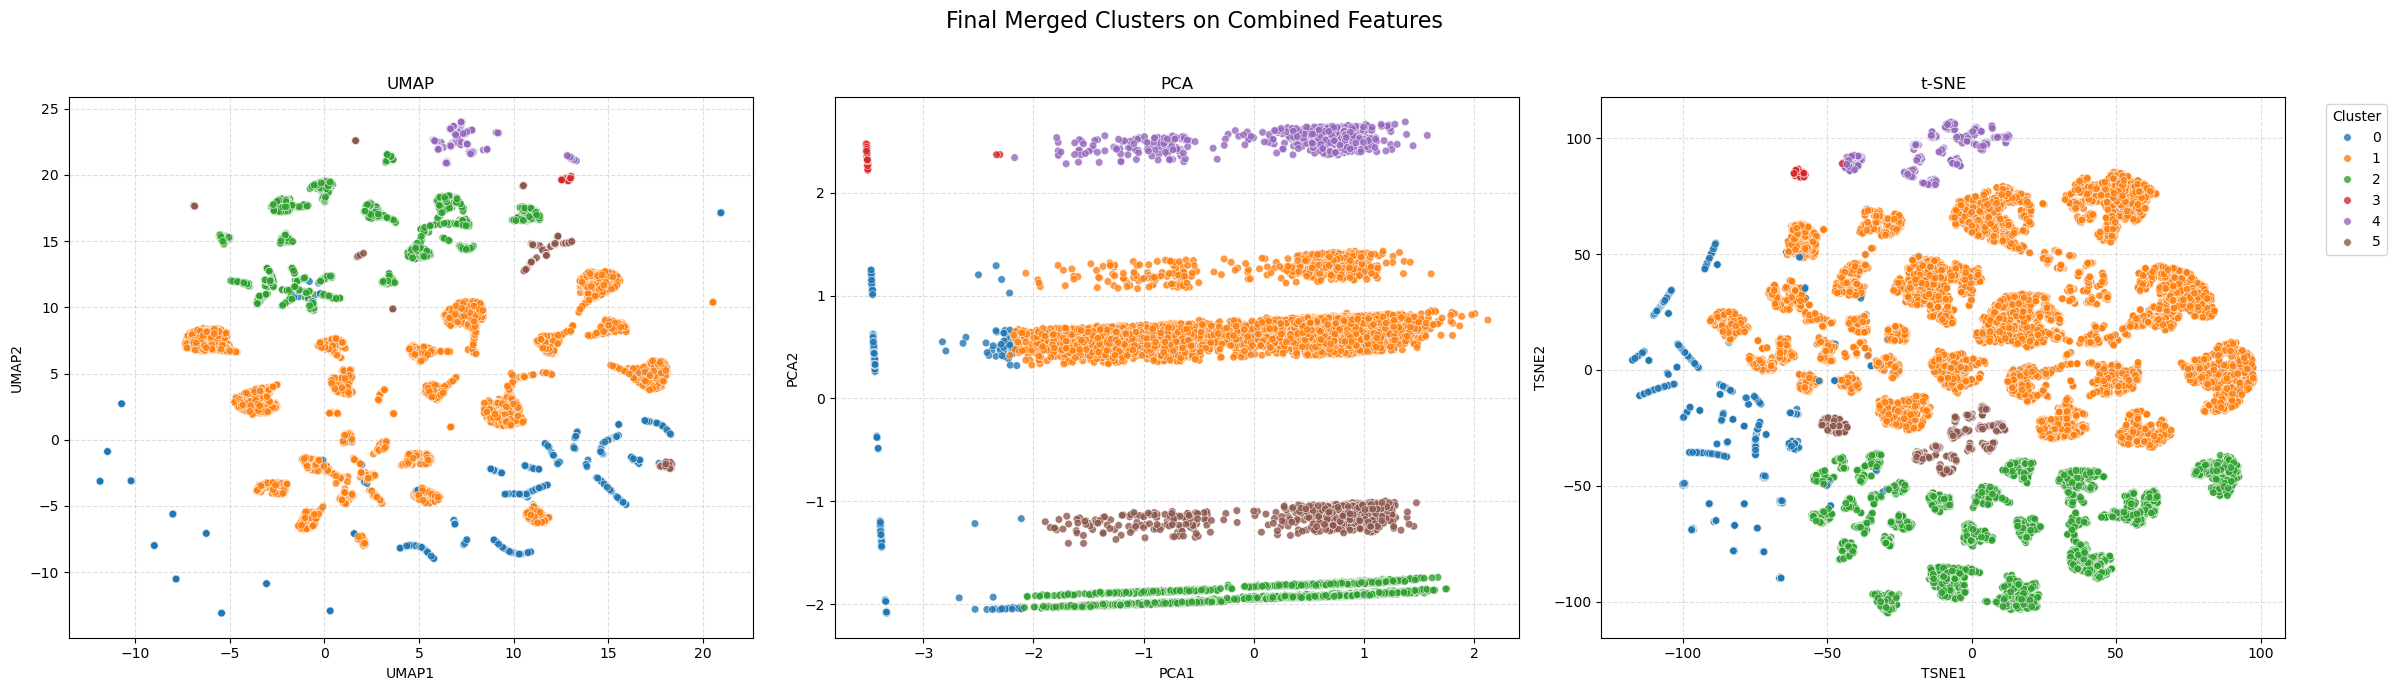

In [32]:
# Visualize final clusters on UMAP
umap_final_df = apply_umap_2d(final_df[combined_features])
pca_final_df = apply_pca_2d(final_df[combined_features])
tsne_final_df = apply_tsne_2d(final_df[combined_features])

plot_cluster(
    umap_final_df, pca_final_df, tsne_final_df, final_df['merged_labels'],
    main_title="Final Merged Clusters on Combined Features")   

# Profiling

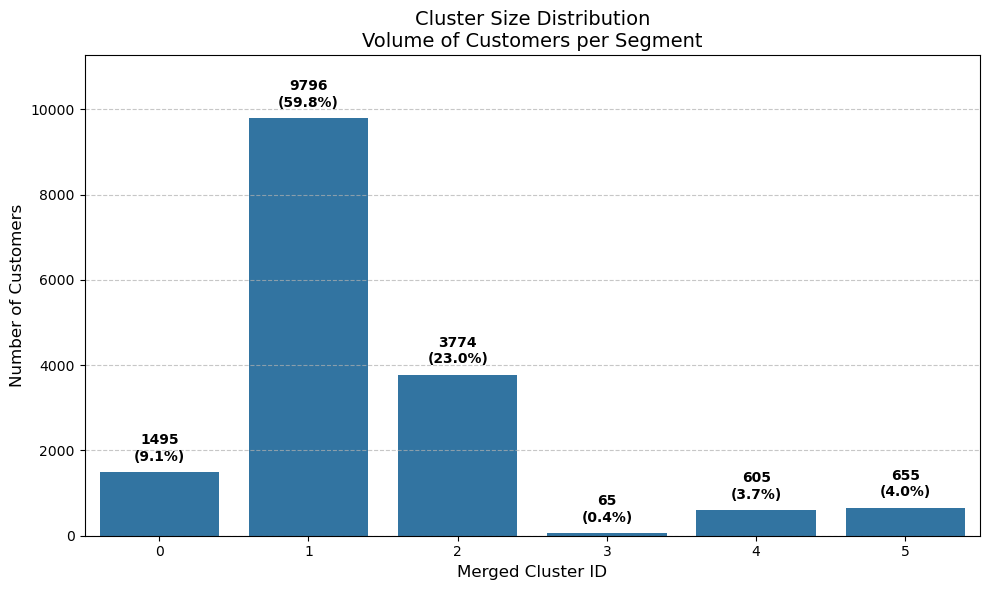

In [33]:
# Calculate the counts and percentages
cluster_counts = final_df['merged_labels'].value_counts().sort_index()
cluster_pcts = (final_df['merged_labels'].value_counts(normalize=True) * 100).sort_index()

# Create the Bar Chart Figure
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x=cluster_counts.index, 
    y=cluster_counts.values, 
)

# Add labels and title
plt.title('Cluster Size Distribution\nVolume of Customers per Segment', fontsize=14)
plt.xlabel('Merged Cluster ID', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)

# Annotate bars with counts and percentages
for i, count in enumerate(cluster_counts.values):
    pct = cluster_pcts.values[i]
    ax.text(
        i, count + (max(cluster_counts)*0.02), 
        f'{count}\n({pct:.1f}%)', 
        ha='center', va='bottom', fontweight='bold', fontsize=10
    )

plt.ylim(0, max(cluster_counts) * 1.15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

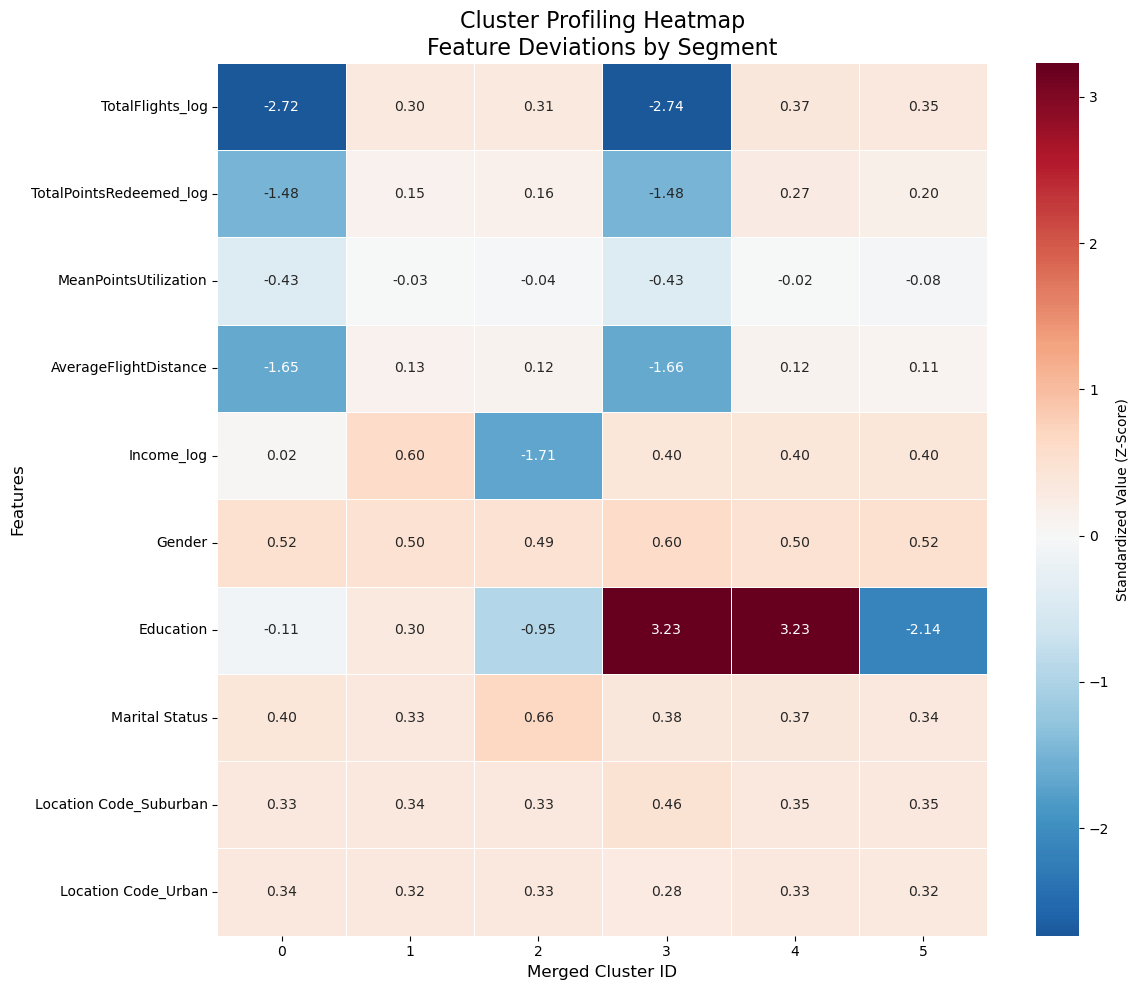

In [34]:

# Calculate the Centroids (Means) for each cluster
df_heatmap = final_df.groupby('merged_labels')[combined_features].mean().T

# Create the Heatmap Figure
plt.figure(figsize=(12, 10))
sns.heatmap(
    df_heatmap, 
    annot=True,
    fmt=".2f", 
    cmap='RdBu_r',
    center=0,
    linewidths=.5,
    cbar_kws={'label': 'Standardized Value (Z-Score)'}
)

plt.title('Cluster Profiling Heatmap\nFeature Deviations by Segment', fontsize=16)
plt.xlabel('Merged Cluster ID', fontsize=12)
plt.ylabel('Features', fontsize=12)

plt.tight_layout()
plt.savefig('figure_1_heatmap.png') # Saving for your report
plt.show()

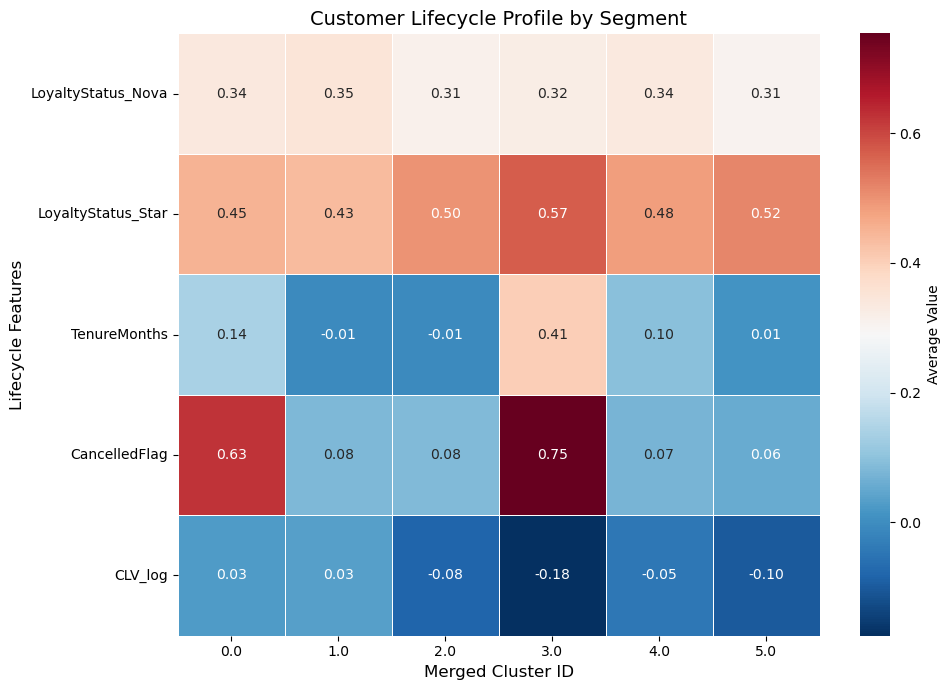

In [35]:
# 1. Bring the labels into the dataframe that has the lifecycle columns
model_df['merged_labels'] = final_df['merged_labels']

# 2. Group and calculate the means
df_lifecycle = model_df.groupby('merged_labels')[lifecycle_features].mean().T

# 3. Create the Heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(
    df_lifecycle, 
    annot=True,
    fmt=".2f",
    cmap='RdBu_r',       
    linewidths=.5,
    cbar_kws={'label': 'Average Value'}
)

plt.title('Customer Lifecycle Profile by Segment', fontsize=14)
plt.xlabel('Merged Cluster ID', fontsize=12)
plt.ylabel('Lifecycle Features', fontsize=12)

plt.tight_layout()
plt.show()

In [36]:
final_df

TotalFlights_log  TotalPointsRedeemed_log  MeanPointsUtilization  \
Loyalty#                                                                     
480934            0.522795                 0.738129              -0.246381   
549612            0.776343                 0.807722               0.405034   
429460            0.232401                 0.529479               0.224053   
608370            0.546334                 0.784274               0.378357   
530508            0.461702                -1.479347              -0.429428   
...                    ...                      ...                    ...   
100012           -2.785853                -1.479347              -0.429428   
100013           -2.785853                -1.479347              -0.429428   
100014           -2.785853                -1.479347              -0.429428   
100015           -2.785853                -1.479347              -0.429428   
100016           -2.785853                -1.479347              -0.429428   

          AverageFlightDistance  Income_log  Gender  Education  \
Loyalty#                                                         
480934                 0.592418    0.677739       1   0.247015   
549612                -0.431266   -1.710038       0  -0.946877   
429460                -0.101999   -1.710038       0  -0.946877   
608370                 0.032897   -1.710038       0  -0.946877   
530508                 0.130452    0.748927       0   0.247015   
...                         ...         ...     ...        ...   
100012                -1.671640    0.501727       0   0.247015   
100013                -1.671640    0.501727       1   0.247015   
100014                -1.671640    0.501727       0   0.247015   
100015                -1.671640    0.501727       1  -0.946877   
100016                -1.671640    0.501727       1   1.440906   

          Marital Status  Location Code_Suburban  Location Code_Urban  \
Loyalty#                                                                
480934                 0                       0                    1   
549612                 1                       0                    0   
429460                 1                       0                    1   
608370                 1                       1                    0   
530508                 0                       1                    0   
...                  ...                     ...                  ...   
100012                 1                       1                    0   
100013                 0                       0                    0   
100014                 0                       0                    0   
100015                 0                       0                    1   
100016                 1                       1                    0   

          behavior_cluster  profile_cluster  merged_labels  
Loyalty#                                                    
480934                   0                0              1  
549612                   0                1              2  
429460                   0                1              2  
608370                   0                1              2  
530508                   1                0              1  
...                    ...              ...            ...  
100012                   2                0              0  
100013                   2                0              0  
100014                   2                0              0  
100015                   2                0              0  
100016                   2                0              0  

[16390 rows x 13 columns]

# Feature Importance Analysis

Use Random Forest Classifier to identify which features are most important for predicting the merged cluster labels.


In [37]:
# Train Random Forest Classifier on combined features with merged labels
X_train = final_df[combined_features]
y_train = final_df['merged_labels']

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Get feature importances
feature_importance_df = pd.DataFrame({
    'Feature': combined_features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"\nTop 10 Most Important Features:")
print(feature_importance_df.head(10))



Top 10 Most Important Features:
                   Feature  Importance
6                Education    0.487583
4               Income_log    0.254586
3    AverageFlightDistance    0.122038
0         TotalFlights_log    0.108062
1  TotalPointsRedeemed_log    0.011655
2    MeanPointsUtilization    0.009267
7           Marital Status    0.005614
5                   Gender    0.000425
9      Location Code_Urban    0.000395
8   Location Code_Suburban    0.000374


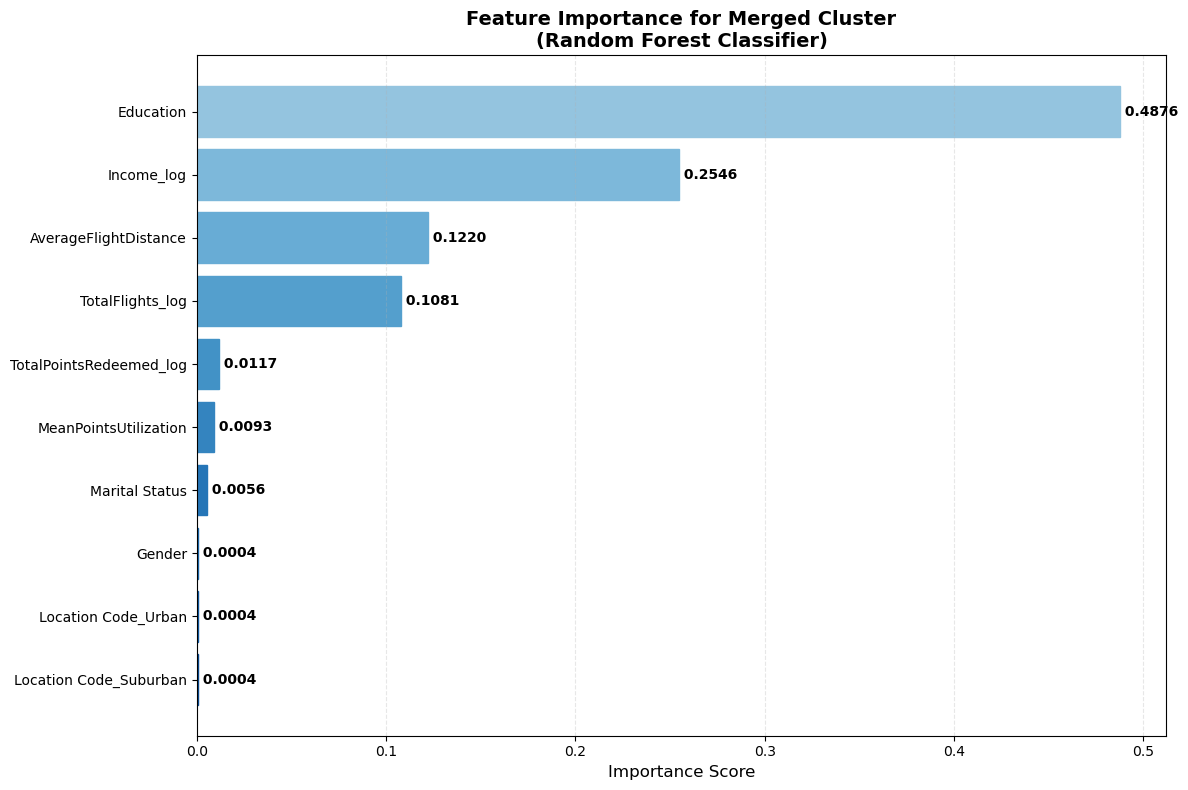

In [38]:
# Visualize Feature Importance
fig, ax = plt.subplots(figsize=(12, 8))

top_n = 20
top_features = feature_importance_df.head(top_n)

bars = ax.barh(range(len(top_features)), top_features['Importance'].values, color='steelblue')

colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(top_features)))
for bar, color in zip(bars, colors):
    bar.set_color(color)

ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'].values)
ax.set_xlabel('Importance Score', fontsize=12)
ax.set_title(f'Feature Importance for Merged Cluster\n(Random Forest Classifier)', fontsize=14, fontweight='bold')
ax.invert_yaxis()

for i, (idx, row) in enumerate(top_features.iterrows()):
    ax.text(row['Importance'], i, f" {row['Importance']:.4f}", va='center', fontweight='bold')

plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()


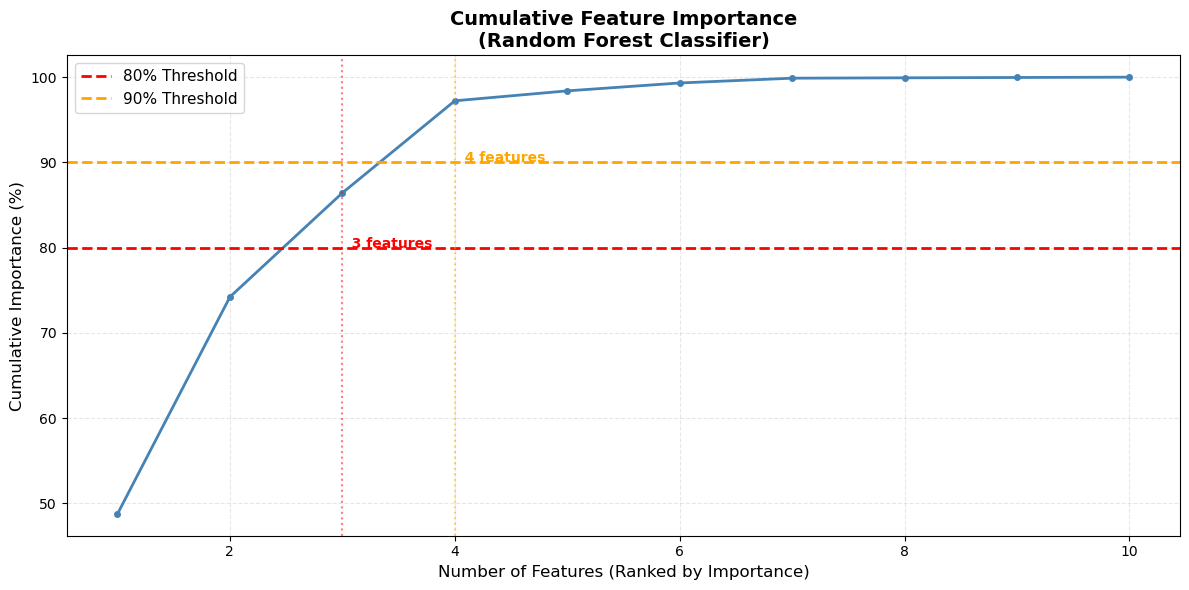


Number of features needed for 80% importance: 3
Number of features needed for 90% importance: 4


In [39]:
# Cumulative Feature Importance Plot
cumulative_importance = np.cumsum(feature_importance_df['Importance'].values)
cumulative_percentage = (cumulative_importance / cumulative_importance[-1]) * 100

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(range(1, len(cumulative_percentage) + 1), cumulative_percentage, 
        marker='o', linestyle='-', linewidth=2, markersize=4, color='steelblue')

ax.axhline(y=80, color='red', linestyle='--', linewidth=2, label='80% Threshold')
ax.axhline(y=90, color='orange', linestyle='--', linewidth=2, label='90% Threshold')

# Find number of features for 80% and 90% importance
n_features_80 = np.argmax(cumulative_percentage >= 80) + 1
n_features_90 = np.argmax(cumulative_percentage >= 90) + 1

ax.axvline(x=n_features_80, color='red', linestyle=':', alpha=0.5)
ax.axvline(x=n_features_90, color='orange', linestyle=':', alpha=0.5)

ax.set_xlabel('Number of Features (Ranked by Importance)', fontsize=12)
ax.set_ylabel('Cumulative Importance (%)', fontsize=12)
ax.set_title('Cumulative Feature Importance\n(Random Forest Classifier)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(fontsize=11)

ax.text(n_features_80, 80, f'\n  {n_features_80} features', fontsize=10, color='red', fontweight='bold')
ax.text(n_features_90, 90, f'\n  {n_features_90} features', fontsize=10, color='orange', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nNumber of features needed for 80% importance: {n_features_80}")
print(f"Number of features needed for 90% importance: {n_features_90}")


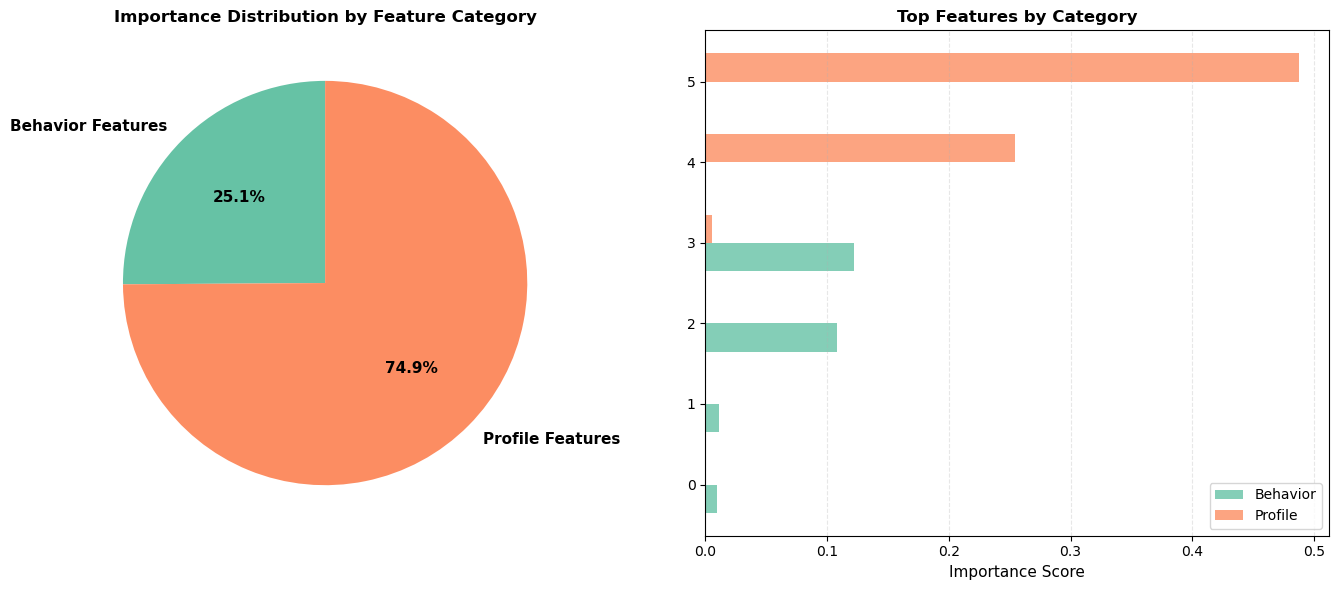


Importance Summary by Category:
            Category  Total Importance
0  Behavior Features          0.251023
1   Profile Features          0.748977

Top 5 Behavior Features:
                   Feature  Importance
3    AverageFlightDistance    0.122038
0         TotalFlights_log    0.108062
1  TotalPointsRedeemed_log    0.011655
2    MeanPointsUtilization    0.009267

Top 5 Profile Features:
               Feature  Importance
6            Education    0.487583
4           Income_log    0.254586
7       Marital Status    0.005614
5               Gender    0.000425
9  Location Code_Urban    0.000395


In [40]:
# Feature Importance by Category (Behavior vs Profile)
behavior_importance = feature_importance_df[feature_importance_df['Feature'].isin(behavior_features)].copy()
profile_importance = feature_importance_df[feature_importance_df['Feature'].isin(profile_features)].copy()

# Calculate aggregate importance by category
category_importance = pd.DataFrame({
    'Category': ['Behavior Features', 'Profile Features'],
    'Total Importance': [
        behavior_importance['Importance'].sum(),
        profile_importance['Importance'].sum()
    ]
})

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

colors_pie = ['#66c2a5', '#fc8d62']
axes[0].pie(category_importance['Total Importance'], 
            labels=category_importance['Category'], 
            autopct='%1.1f%%',
            colors=colors_pie,
            startangle=90,
            textprops={'fontsize': 11, 'weight': 'bold'})
axes[0].set_title('Importance Distribution by Feature Category', fontsize=12, fontweight='bold')

# Bar chart comparing top features from each category
top_behavior = behavior_importance.head(10)
top_profile = profile_importance.head(10)

# Use the maximum number of features across both categories
max_features = max(len(top_behavior), len(top_profile))
y_pos = np.arange(max_features)
width = 0.35

# Pad with zeros if one has fewer features than the other
behavior_values = np.pad(top_behavior['Importance'].values[::-1], (0, max_features - len(top_behavior)), mode='constant')
profile_values = np.pad(top_profile['Importance'].values[::-1], (0, max_features - len(top_profile)), mode='constant')

axes[1].barh(y_pos - width/2, behavior_values, width, 
             label='Behavior', color='#66c2a5', alpha=0.8)
axes[1].barh(y_pos + width/2, profile_values, width, 
             label='Profile', color='#fc8d62', alpha=0.8)

axes[1].set_yticks(y_pos)
axes[1].set_xlabel('Importance Score', fontsize=11)
axes[1].set_title('Top Features by Category', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("\nImportance Summary by Category:")
print(category_importance)
print(f"\nTop 5 Behavior Features:")
print(behavior_importance.head(5))
print(f"\nTop 5 Profile Features:")
print(profile_importance.head(5))
